<a href="https://colab.research.google.com/github/Piyushiitk24/dc-motor-signed-bias-deadzone-id-control/blob/main/DC_Motor_ID_SignedBias_DeadZone_IMCPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
USE_INTERACTIVE = True

USE_HOVER = True

# ---- default export folder for figures ----
FIG_DIR = OUT_DIR if 'OUT_DIR' in globals() else '.'

if USE_INTERACTIVE:
    try:
        from google.colab import output
        output.enable_custom_widget_manager()
        import sys
        if 'ipympl' not in sys.modules:
            import subprocess, sys as _sys
            subprocess.run([_sys.executable, "-m", "pip", "install", "-q", "ipympl", "mplcursors"], check=False)

        import matplotlib
        import matplotlib.pyplot as plt
        get_ipython().run_line_magic("matplotlib", "widget")
    except Exception as _e:

        import matplotlib.pyplot as plt
        get_ipython().run_line_magic("matplotlib", "inline")
        USE_INTERACTIVE = False
else:
    import matplotlib.pyplot as plt
    get_ipython().run_line_magic("matplotlib", "inline")

# ---- house style (rcParams) ----
import matplotlib as mpl
from cycler import cycler
mpl.rcParams.update({
    "figure.dpi": 130,
    "savefig.dpi": 150,
    "figure.figsize": (12, 5),
    "font.size": 12,
    "font.family": "DejaVu Sans",
    "axes.titlesize": 15,
    "axes.labelsize": 13,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.prop_cycle": cycler(color=[
        "#3366CC","#DC3912","#109618","#FF9900",
        "#990099","#0099C6","#DD4477","#66AA00"
    ]),
    "legend.frameon": True,
    "legend.framealpha": 0.9,
    "legend.facecolor": "#FFFFFF",
    "legend.borderaxespad": 0.6,
    "lines.linewidth": 2.0,
    "axes.formatter.useoffset": False,
})

# ---- helpers: new figure / savefig / annotate ----
import os, numpy as np

def newfig(figsize=None, title=None, xlabel=None, ylabel=None, sharex=False):
    fig, ax = plt.subplots(1, 1, figsize=figsize or (12,5), sharex=sharex)
    if title:  ax.set_title(title)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    return fig, ax

def savefig(fig, name, subdir=FIG_DIR):
    os.makedirs(subdir, exist_ok=True)
    png = os.path.join(subdir, f"{name}.png")
    svg = os.path.join(subdir, f"{name}.svg")
    fig.tight_layout()
    fig.savefig(png, bbox_inches="tight")
    fig.savefig(svg, bbox_inches="tight")
    print(f"Saved: {png} and {svg}")

def attach_hover(ax, fmt="x={x:.2f}, y={y:.1f}"):
    if not USE_INTERACTIVE or not USE_HOVER:
        return
    try:
        import mplcursors
        lines = [ln for ln in ax.lines if ln.get_visible()]
        if lines:
            cursor = mplcursors.cursor(lines, hover=True)
            @cursor.connect("add")
            def _on_add(sel):
                x, y = sel.target
                sel.annotation.set_text(fmt.format(x=x, y=y))
    except Exception:
        pass

def step_caption(ax, text):
    ax.text(0.01, 0.98, text, transform=ax.transAxes, va="top", ha="left",
            fontsize=11, color="#444", bbox=dict(facecolor="white", alpha=0.7, boxstyle="round,pad=0.3"))

In [ ]:
# ===============================================
# DC MOTOR MODELLING — Section 0: Setup
# Hammerstein: Dead-Zone(±Vdb) → First-Order TF (+ optional signed bias & delay)
# ===============================================

import warnings; warnings.filterwarnings("ignore")

try:
    from google.colab import drive, output
    drive.mount("/content/drive")
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# ---- Paths ----
import os
CSV_PATH  = '/content/drive/MyDrive/Master_Archive/60_Academics/Projects/Thesis/run_minimal.csv'
MAP_PATH  = '/content/drive/MyDrive/Master_Archive/60_Academics/Projects/Thesis/Voltage_PWM_RPM_Mapping.csv'
OUT_DIR   = '/content/drive/MyDrive/Master_Archive/60_Academics/Projects/Thesis'
os.makedirs(OUT_DIR, exist_ok=True)
STEP_PLOTS_DIR = os.path.join(OUT_DIR, 'steps'); os.makedirs(STEP_PLOTS_DIR, exist_ok=True)

# ---- Core imports ----
import math
import numpy as np
import pandas as pd

# SciPy bits used later in the notebook
from scipy import stats
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, lsim, TransferFunction
from scipy.interpolate import PchipInterpolator
from numpy.polynomial import Chebyshev

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

# ---- DataFrame display helper ----
from IPython.display import display
def show_table(df, caption=None):
    if caption: print(caption)
    if IN_COLAB:
        try:
            from google.colab import data_table
            data_table.enable_dataframe_formatter()
            display(data_table.DataTable(df, include_index=False, num_rows_per_page=15))
            return
        except Exception:
            pass
    try:
        display(df)
    except Exception:
        print(df.to_string(index=False))

# ---- Modelling defaults ----
VDB_POS_DEFAULT = 3.5   # +V dead-zone for modelling
VDB_NEG_DEFAULT = 3.5   # −V dead-zone for modelling
SOFT_ALPHA_DEFAULT = 0.00  # 0 = hard dead-zone
print(f"Dead-Zone defaults pinned: +{VDB_POS_DEFAULT:.2f} V / -{VDB_NEG_DEFAULT:.2f} V (alpha={SOFT_ALPHA_DEFAULT:.2f})")

USE_INTERACTIVE = True
USE_HOVER = True

if USE_INTERACTIVE and IN_COLAB:
    try:
        output.enable_custom_widget_manager()
        import subprocess, sys as _sys
        subprocess.run([_sys.executable, "-m", "pip", "install", "-q", "ipympl", "mplcursors"], check=False)
        get_ipython().run_line_magic("matplotlib", "widget")
    except Exception:
        get_ipython().run_line_magic("matplotlib", "inline")
        USE_INTERACTIVE = False
else:
    get_ipython().run_line_magic("matplotlib", "inline")
    USE_INTERACTIVE = False if not IN_COLAB else USE_INTERACTIVE

# House style (rcParams)
from cycler import cycler
mpl.rcParams.update({
    "figure.dpi": 130, "savefig.dpi": 150, "figure.figsize": (12, 5),
    "font.size": 12, "font.family": "DejaVu Sans",
    "axes.titlesize": 15, "axes.labelsize": 13,
    "axes.grid": True, "grid.alpha": 0.25,
    "axes.spines.top": False, "axes.spines.right": False,
    "axes.prop_cycle": cycler(color=[
        "#3366CC","#DC3912","#109618","#FF9900",
        "#990099","#0099C6","#DD4477","#66AA00"
    ]),
    "legend.frameon": True, "legend.framealpha": 0.9,
    "legend.facecolor": "#FFFFFF", "legend.borderaxespad": 0.6,
    "lines.linewidth": 2.0, "axes.formatter.useoffset": False,
})

# Figure helpers
def newfig(figsize=None, title=None, xlabel=None, ylabel=None, sharex=False):
    fig, ax = plt.subplots(1, 1, figsize=figsize or (12,5), sharex=sharex)
    if title:  ax.set_title(title)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    return fig, ax

def savefig(fig, name, subdir=OUT_DIR):
    os.makedirs(subdir, exist_ok=True)
    fig.tight_layout()
    fig.savefig(os.path.join(subdir, f"{name}.png"), bbox_inches="tight")
    fig.savefig(os.path.join(subdir, f"{name}.svg"), bbox_inches="tight")
    print(f"Saved: {os.path.join(subdir, name+'.png')} and .svg")

def attach_hover(ax, fmt="x={x:.2f}, y={y:.1f}"):
    if not (USE_INTERACTIVE and USE_HOVER and IN_COLAB):
        return
    try:
        import mplcursors
        lines = [ln for ln in ax.lines if ln.get_visible()]
        if lines:
            cursor = mplcursors.cursor(lines, hover=True)
            @cursor.connect("add")
            def _on_add(sel):
                x, y = sel.target
                sel.annotation.set_text(fmt.format(x=x, y=y))
    except Exception:
        pass

def step_caption(ax, text):
    ax.text(0.01, 0.98, text, transform=ax.transAxes, va="top", ha="left",
            fontsize=11, color="#444",
            bbox=dict(facecolor="white", alpha=0.75, boxstyle="round,pad=0.3"))

print("Setup complete. Interactivity:", "ON" if USE_INTERACTIVE else "OFF")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dead-Zone defaults pinned: +3.50 V / -3.50 V (alpha=0.00)
Setup complete. Interactivity: OFF


Mapping rows: 40 | RMSE PCHIP=0.00 | Cheby(deg=5)=3.13 | Auto-select: PCHIP
(Using FIXED Dead-Zone for modeling: +3.50 V / -3.50 V)
Saved: /content/drive/MyDrive/Master_Archive/60_Academics/Projects/Thesis/mapping_pchip_vs_cheby.png and .svg


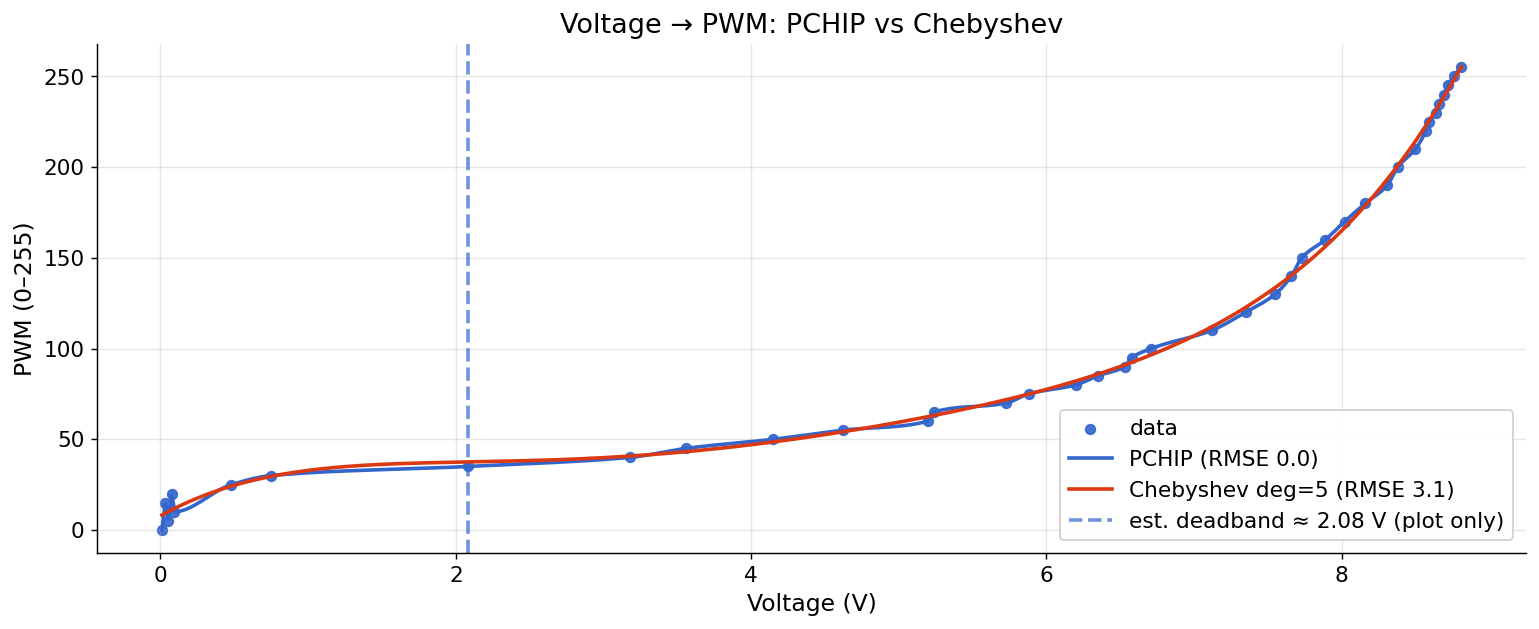

Mapping preview (first 20 rows)


,voltage,pwm,rpm
0,0.01,0.0,0.000000
1,0.03,15.0,0.000000
2,0.05,5.0,0.000000
3,0.08,20.0,0.010000
4,0.09,10.0,0.000667
5,0.48,25.0,4.401000
6,0.75,30.0,15.898333
7,2.08,35.0,49.776000
8,3.18,40.0,49.049333
9,3.56,45.0,93.604000


PCHIP is the default mapper: it preserves the calibration shape, stays monotone and bounded on the measured range, and avoids polynomial oscillations. Chebyshev is used only if it is >5% lower RMSE and passes monotonicity/bounds checks. The dashed line is an estimated deadband for visualization only; the modeling dead-zone remains fixed by VDB_POS_DEFAULT/VDB_NEG_DEFAULT.
Voltage→PWM (auto): [  0   0  46  76 168]
PWM→Voltage (lookup): [0.01       5.22876767 7.51787877 8.32666871 8.81      ]


In [ ]:
# ===============================================
# SECTION 1 — Voltage–PWM–RPM Mapping
# ===============================================

# 1) Load & tidy
map_df = pd.read_csv(MAP_PATH)
map_df.columns = [c.strip().lower() for c in map_df.columns]
required = {'voltage','pwm','rpm'}
assert required.issubset(map_df.columns), f"Mapping CSV must contain columns: {required}"

# keep needed cols → drop NaNs → collapse duplicates (median) → sort
map_df = (map_df[['voltage','pwm','rpm']]
          .dropna()
          .groupby('voltage', as_index=False)
          .agg({'pwm':'median','rpm':'median'})
          .sort_values('voltage')
          .reset_index(drop=True))

V_map = map_df['voltage'].to_numpy(float)
P_map = map_df['pwm'].to_numpy(float)
R_map = map_df['rpm'].to_numpy(float)

# 2) Candidate mappers
from scipy.interpolate import PchipInterpolator
from numpy.polynomial import Chebyshev

# PCHIP V→PWM
pchip_V2P = PchipInterpolator(V_map, P_map, extrapolate=True)

# PCHIP inverse PWM→V (collapse duplicate PWM by median voltage)
_rev = (pd.DataFrame({'pwm':P_map,'voltage':V_map})
        .groupby('pwm', as_index=False)['voltage'].median()
        .sort_values('pwm')
        .reset_index(drop=True))
pchip_P2V = PchipInterpolator(_rev['pwm'].to_numpy(float),
                              _rev['voltage'].to_numpy(float),
                              extrapolate=True)

# Chebyshev degree via BIC on V-domain
def _fit_cheby_bic(x, y, deg_range=range(3,9)):
    x = np.asarray(x, float); y = np.asarray(y, float)
    n = len(x); dom = [float(x.min()), float(x.max())]
    best = {'deg':None,'bic':np.inf,'model':None}
    for deg in deg_range:
        ch = Chebyshev.fit(x, y, deg=deg, domain=dom)
        yhat = ch(x)
        rss = float(np.sum((y - yhat)**2)); p = deg + 1
        bic = n*np.log(max(rss/n, 1e-12)) + p*np.log(n)
        if bic < best['bic']:
            best = {'deg':deg,'bic':bic,'model':ch}
    return best

cheby_fit = _fit_cheby_bic(V_map, P_map)
cheby_model = cheby_fit['model']

# 3) Metrics + safety for auto selection
def _rmse(y, yhat): return float(np.sqrt(np.mean((np.asarray(y)-np.asarray(yhat))**2)))
rmse_pchip = _rmse(P_map, pchip_V2P(V_map))
rmse_cheby = _rmse(P_map, cheby_model(V_map)) if cheby_model is not None else np.inf

V_grid = np.linspace(V_map.min(), V_map.max(), 400)
cheby_ok = False
if cheby_model is not None:
    dmin = float(cheby_model.deriv()(V_grid).min())
    vals = cheby_model(V_grid)
    cheby_ok = (dmin >= -1e-6) and np.all((vals >= -1e-6) & (vals <= 255+1e-6))

# prefer PCHIP; switch only if Chebyshev is clearly better (>5%) AND safe
SELECTED_METHOD = 'pchip'
if cheby_ok and (rmse_cheby < 0.95*rmse_pchip):
    SELECTED_METHOD = 'cheby'

# 4) Deadband estimate for plot (does NOT override your fixed modeling Vdb)
RPM_THRESHOLD = 44.0
db_cand = map_df.loc[map_df['rpm'] >= RPM_THRESHOLD, 'voltage']
V_DEADBAND_EST = float(db_cand.iloc[0]) if len(db_cand) else float(map_df['voltage'].min())

print(f"Mapping rows: {len(map_df)} | RMSE PCHIP={rmse_pchip:.2f} | "
      f"Cheby(deg={cheby_fit['deg']})={rmse_cheby:.2f} | Auto-select: {SELECTED_METHOD.upper()}")
print(f"(Using FIXED Dead-Zone for modeling: +{VDB_POS_DEFAULT:.2f} V / -{VDB_NEG_DEFAULT:.2f} V)")

# 5) Visualization
fig, ax = newfig(title="Voltage → PWM: PCHIP vs Chebyshev", xlabel="Voltage (V)", ylabel="PWM (0–255)")
ax.scatter(map_df['voltage'], map_df['pwm'], s=28, alpha=0.9, label='data')
ax.plot(V_grid, pchip_V2P(V_grid), lw=2, label=f'PCHIP (RMSE {rmse_pchip:.1f})')
if cheby_model is not None:
    ax.plot(V_grid, cheby_model(V_grid), lw=2, label=f'Chebyshev deg={cheby_fit["deg"]} (RMSE {rmse_cheby:.1f})')
ax.axvline(V_DEADBAND_EST, ls='--', alpha=0.7, label=f'est. deadband ≈ {V_DEADBAND_EST:.2f} V (plot only)')
ax.legend(loc="best")
attach_hover(ax)
savefig(fig, "mapping_pchip_vs_cheby")
plt.show()

show_table(map_df.head(20), caption='Mapping preview (first 20 rows)')

MAPPING_RATIONALE = (
    "PCHIP is the default mapper: it preserves the calibration shape, stays monotone and bounded on the "
    "measured range, and avoids polynomial oscillations. Chebyshev is used only if it is >5% lower RMSE "
    "and passes monotonicity/bounds checks. The dashed line is an estimated deadband for visualization only; "
    "the modeling dead-zone remains fixed by VDB_POS_DEFAULT/VDB_NEG_DEFAULT."
)
print(MAPPING_RATIONALE)


# ===============================================
# SECTION 2 — Unified Voltage↔PWM Mapping API
# ===============================================

def _clip_pwm(x):   return np.clip(np.asarray(x, float), 0, 255)
def _to_1d(a):      return np.asarray(a, float).reshape(-1)

# FIXED modeling dead-zone from Section 0
def _resolve_deadband(v, vdb_pos, vdb_neg):
    v = _to_1d(v)
    vdb_pos = VDB_POS_DEFAULT if (vdb_pos is None) else float(vdb_pos)
    vdb_neg = VDB_NEG_DEFAULT if (vdb_neg is None) else float(vdb_neg)
    return v, vdb_pos, vdb_neg

# Forward: Voltage → PWM
def voltage_to_pwm_pchip(v, vdb_pos=None, vdb_neg=None, round_to_int=True):
    v, vdb_pos, vdb_neg = _resolve_deadband(v, vdb_pos, vdb_neg)
    vdb = np.where(v >= 0.0, vdb_pos, vdb_neg)
    pwm = np.where(np.abs(v) < vdb, 0.0, pchip_V2P(v))
    pwm = _clip_pwm(pwm)
    return pwm.astype(int) if round_to_int else pwm

def voltage_to_pwm_cheby(v, vdb_pos=None, vdb_neg=None, round_to_int=True):
    assert cheby_model is not None, "Chebyshev model not available."
    v, vdb_pos, vdb_neg = _resolve_deadband(v, vdb_pos, vdb_neg)
    vdb = np.where(v >= 0.0, vdb_pos, vdb_neg)
    pwm = np.where(np.abs(v) < vdb, 0.0, cheby_model(v))
    pwm = _clip_pwm(pwm)
    return pwm.astype(int) if round_to_int else pwm

def voltage_to_pwm(v, method='auto', **kwargs):
    m = (SELECTED_METHOD if method=='auto' else method).lower()
    if m == 'pchip': return voltage_to_pwm_pchip(v, **kwargs)
    if m == 'cheby': return voltage_to_pwm_cheby(v, **kwargs)
    raise ValueError("method must be 'auto', 'pchip', or 'cheby'")

# Inverse: PWM → Voltage (robust PCHIP inverse)
def pwm_to_voltage(pwm):
    return pchip_P2V(_clip_pwm(pwm))

# Smoke test
print('Voltage→PWM (auto):', voltage_to_pwm([0, 0.8*VDB_POS_DEFAULT, VDB_POS_DEFAULT+0.2, 6.0, 8.0], method='auto'))
print('PWM→Voltage (lookup):', pwm_to_voltage([0, 64, 128, 192, 255]))

Loaded 10501 samples @ Ts≈0.0100s from: /content/drive/MyDrive/Master_Archive/60_Academics/Projects/Thesis/run_minimal.csv


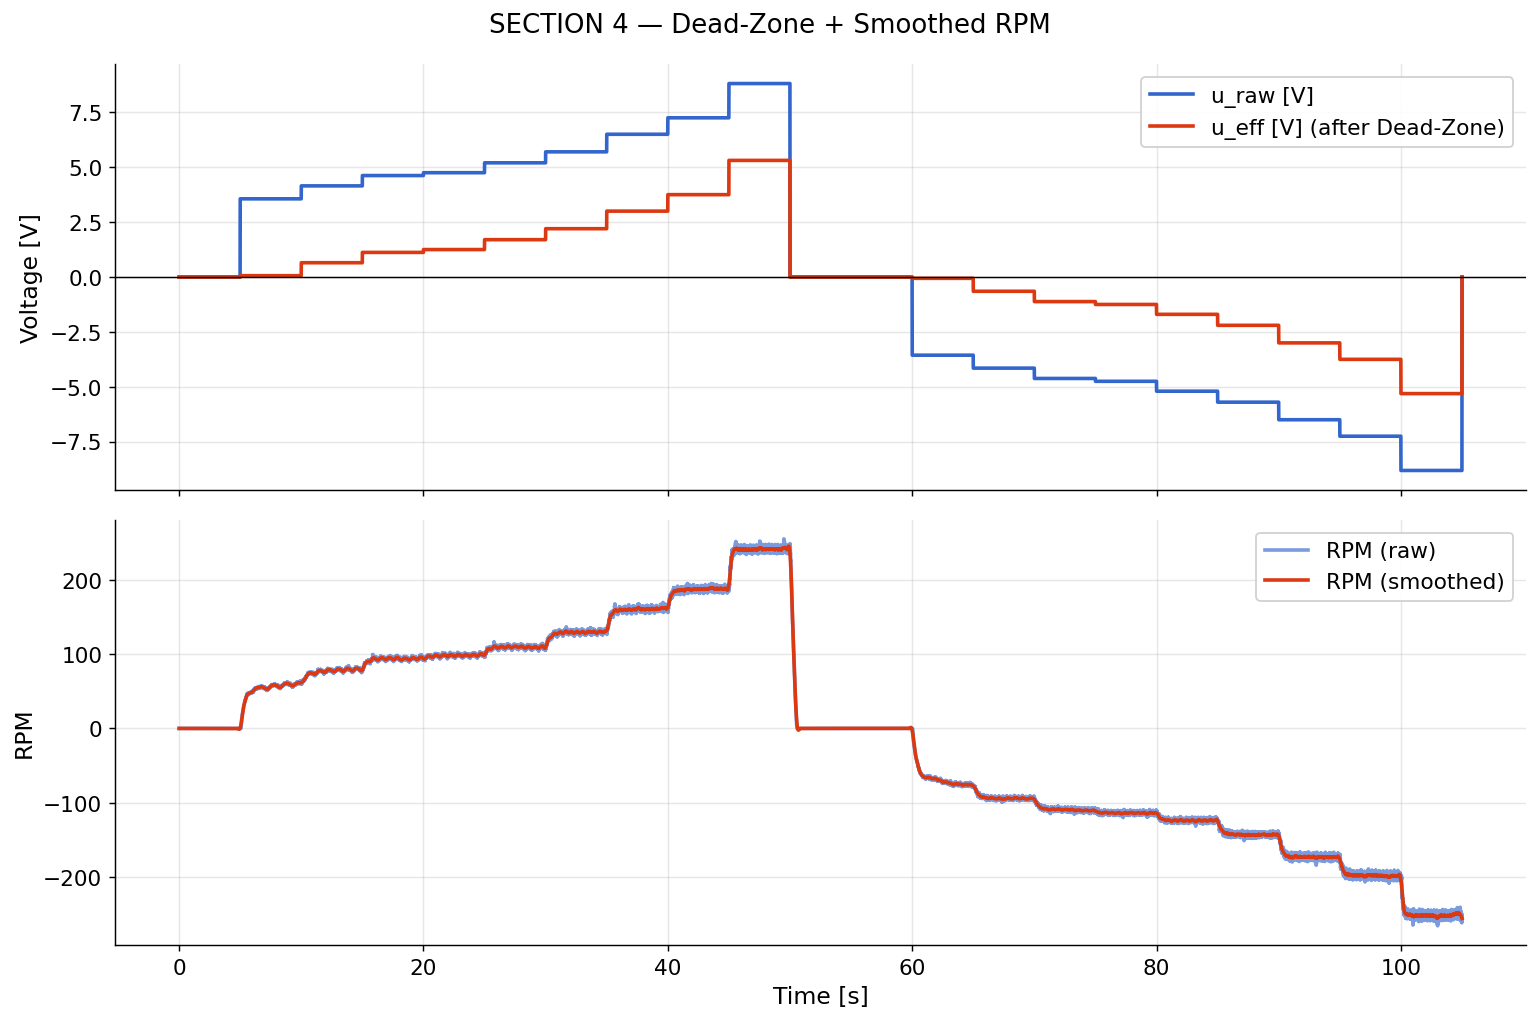

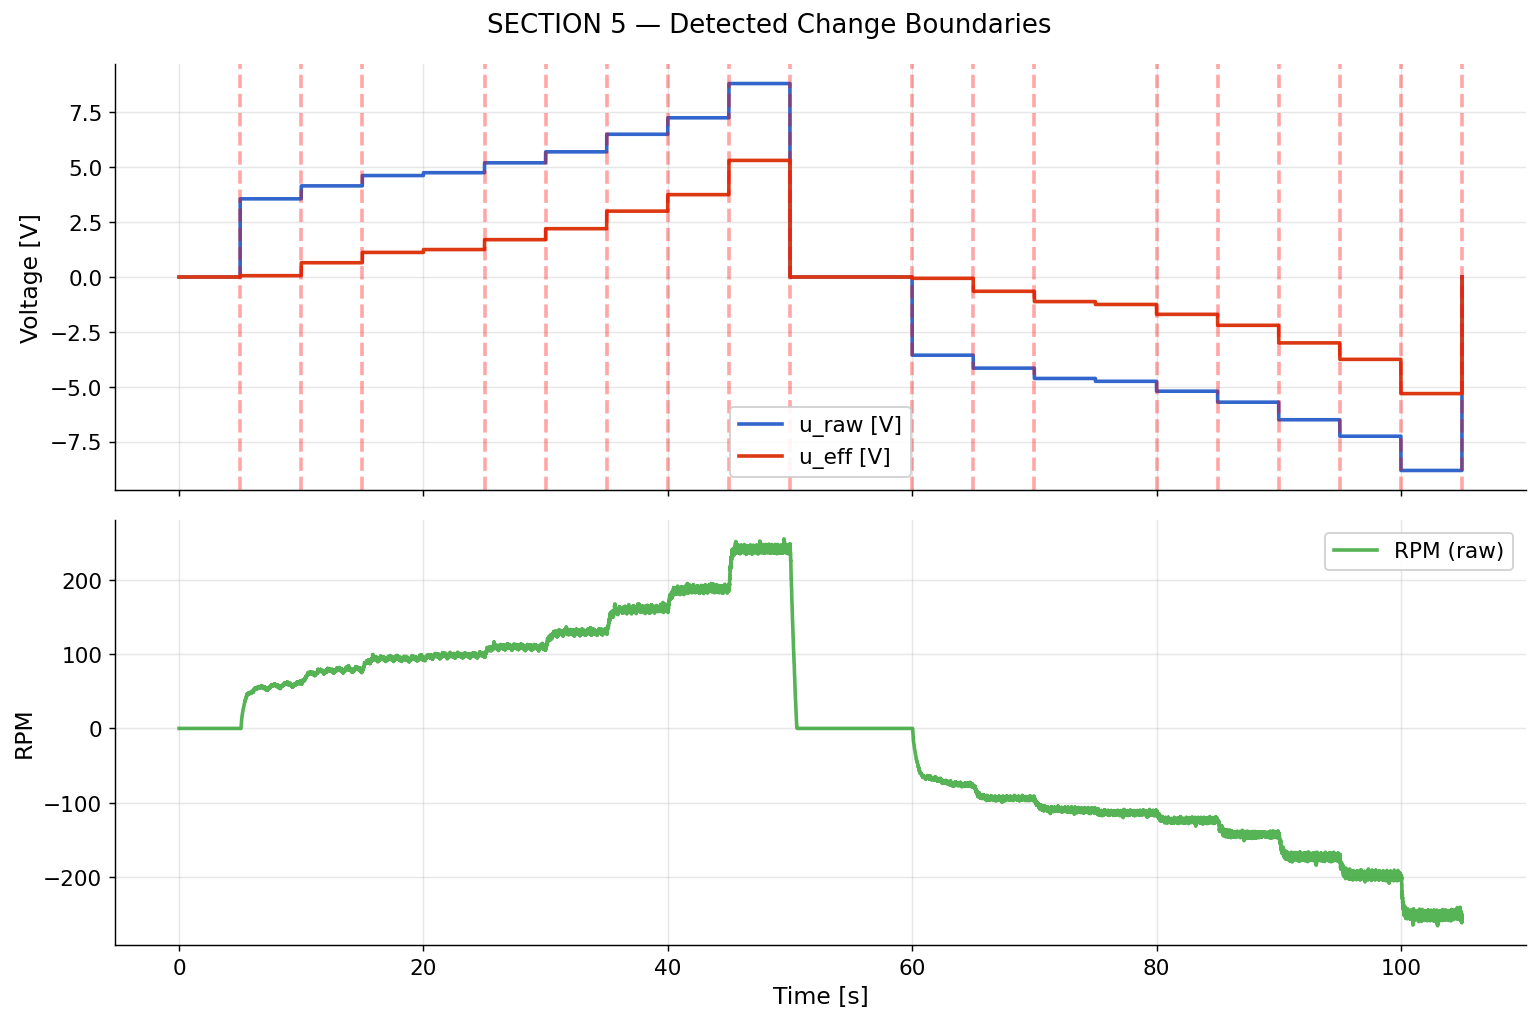

Saved per-step fits → /content/drive/MyDrive/Master_Archive/60_Academics/Projects/Thesis/step_fits.csv


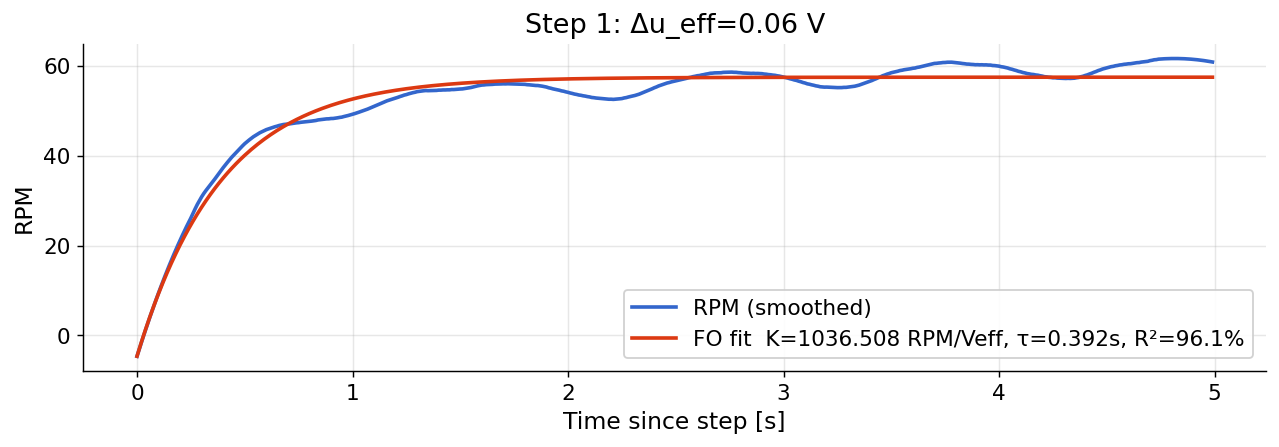

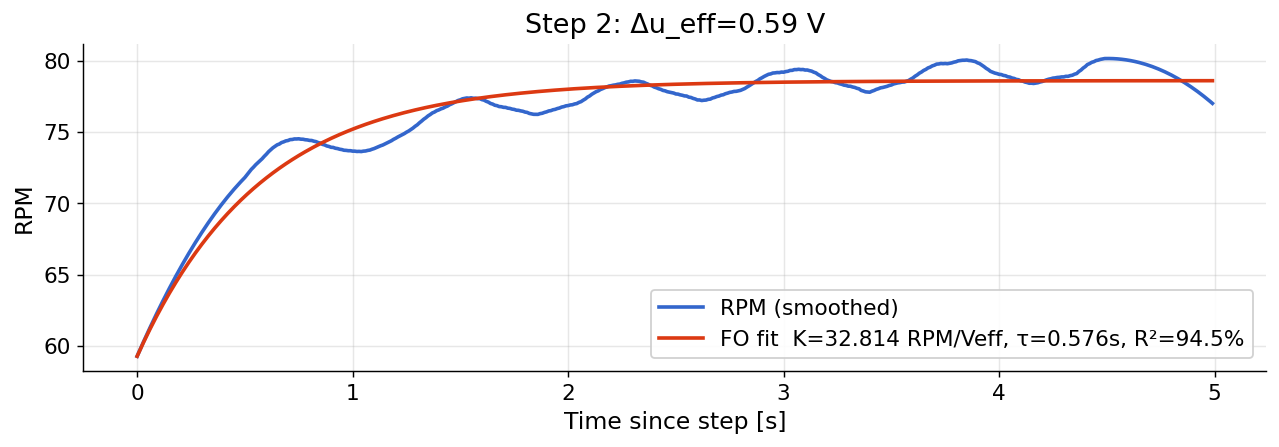

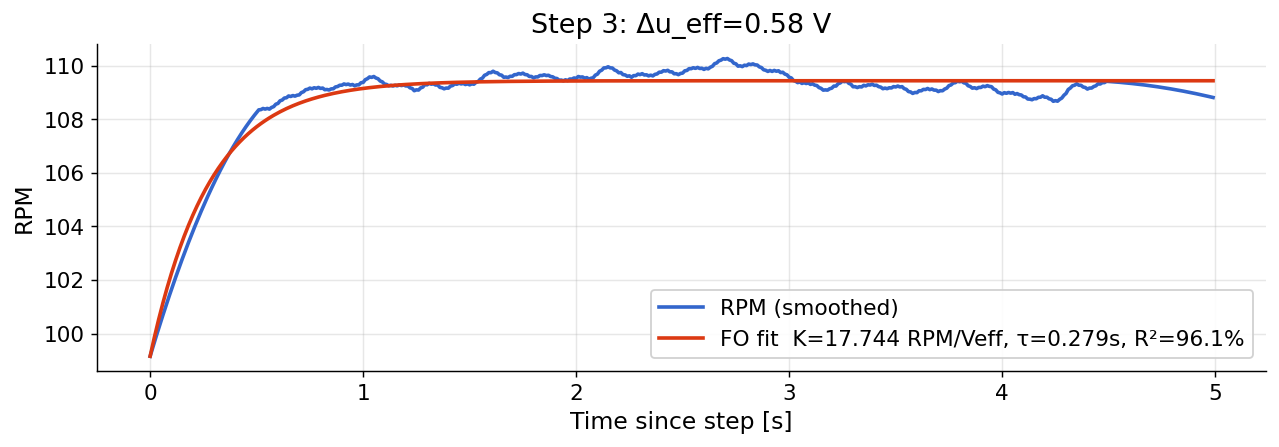

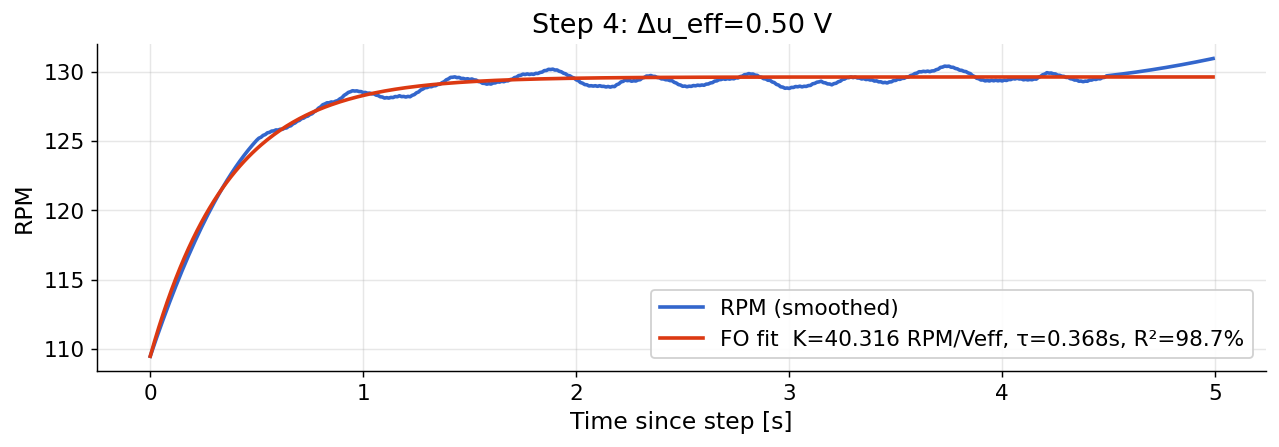

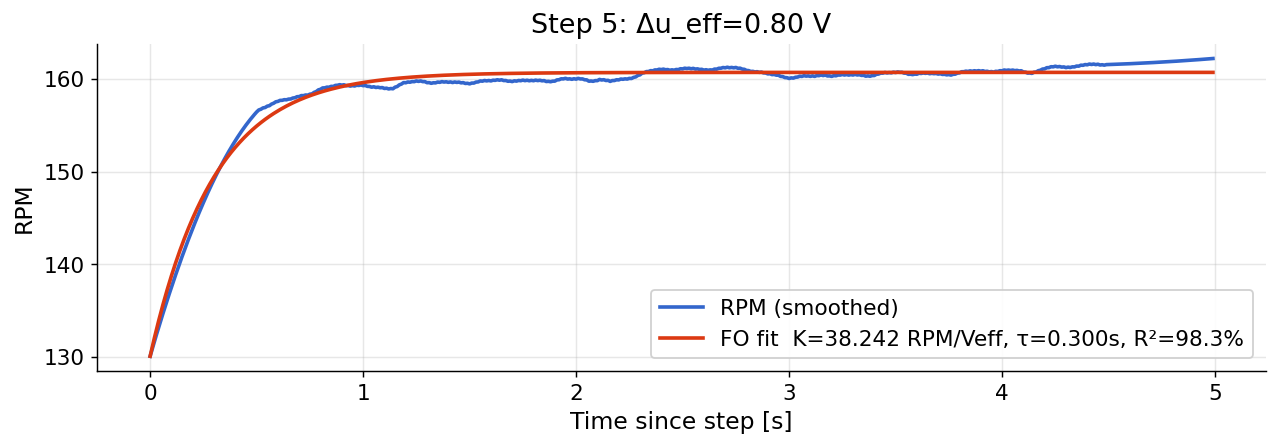

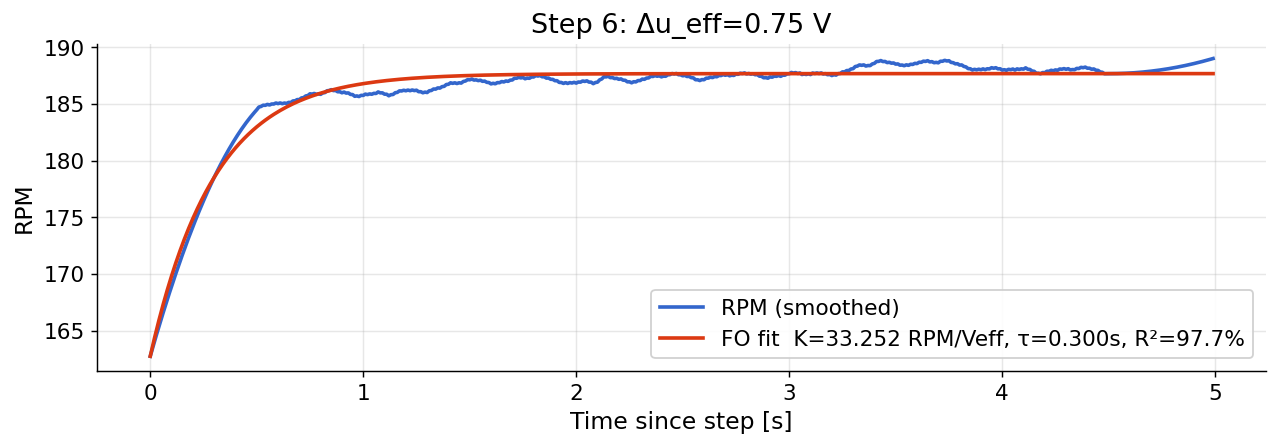

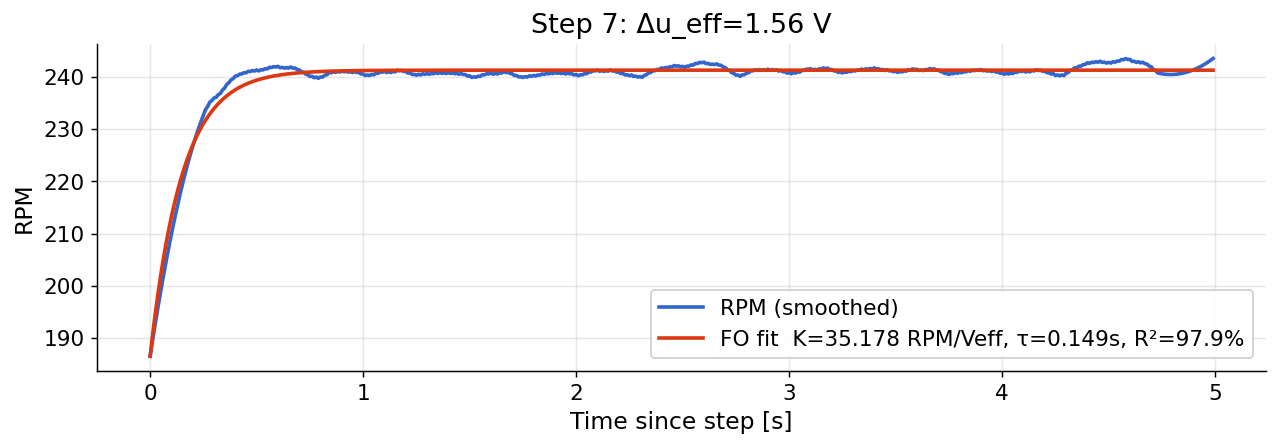

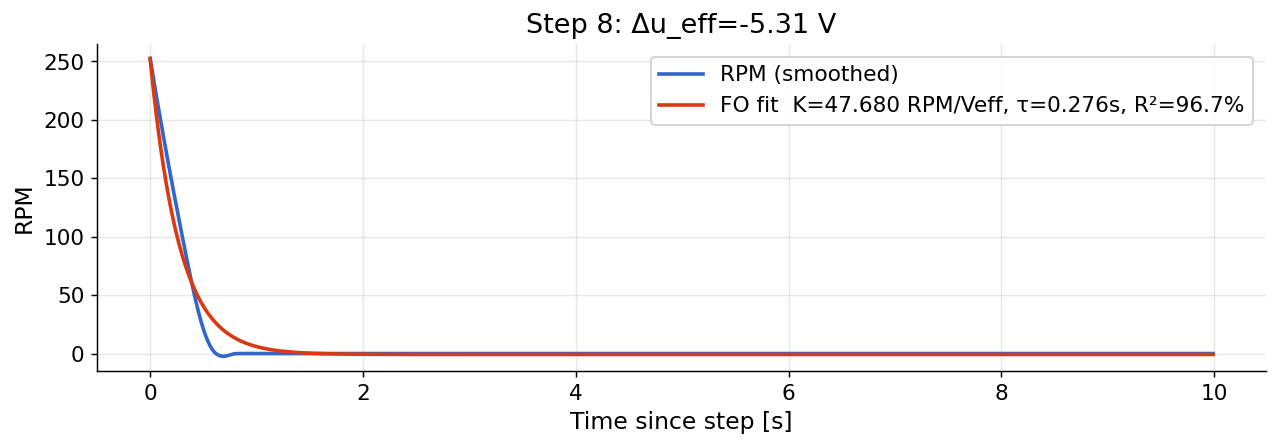

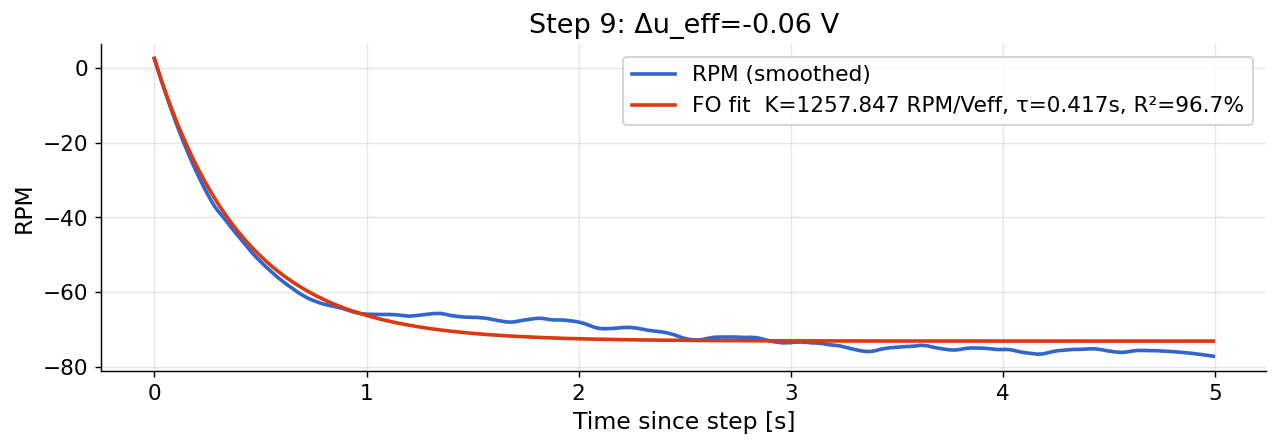

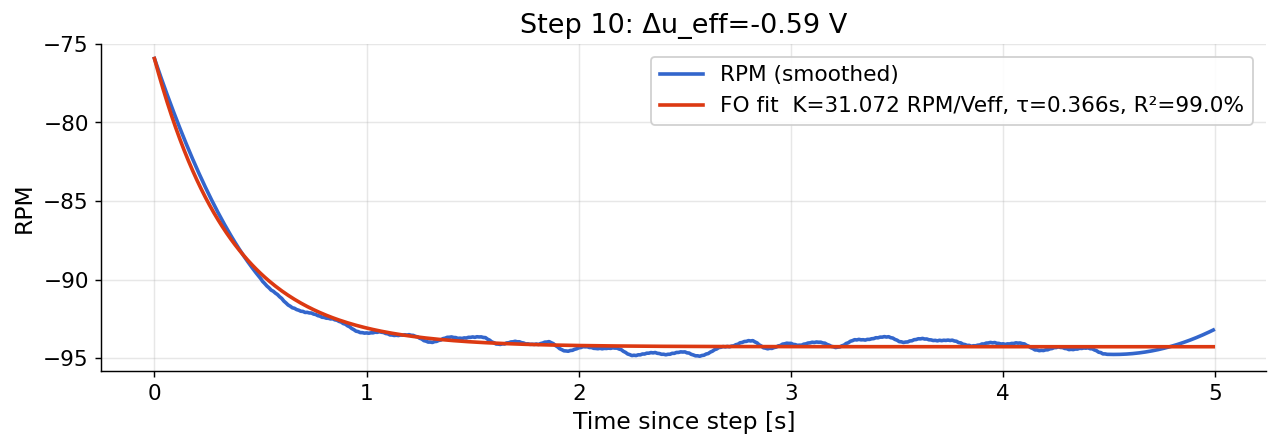

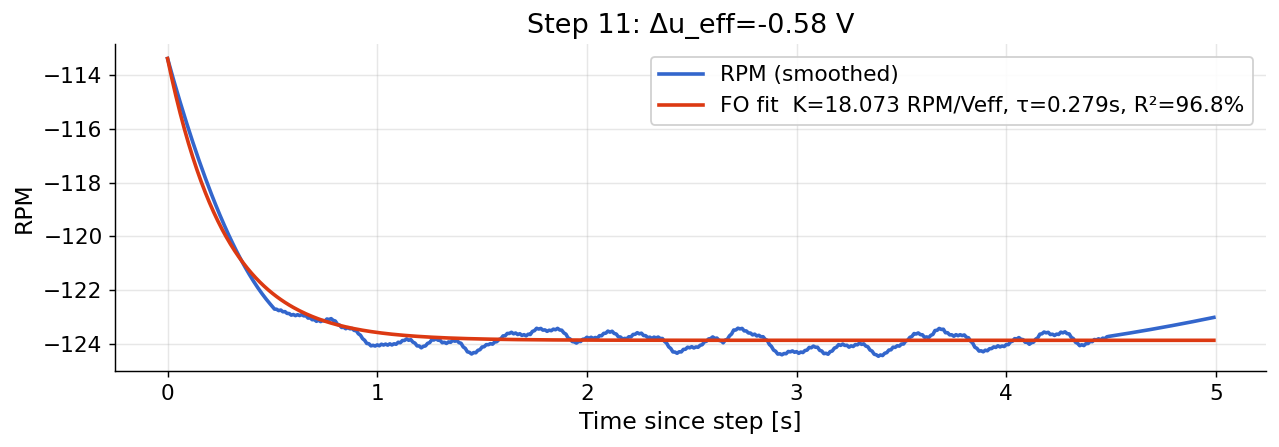

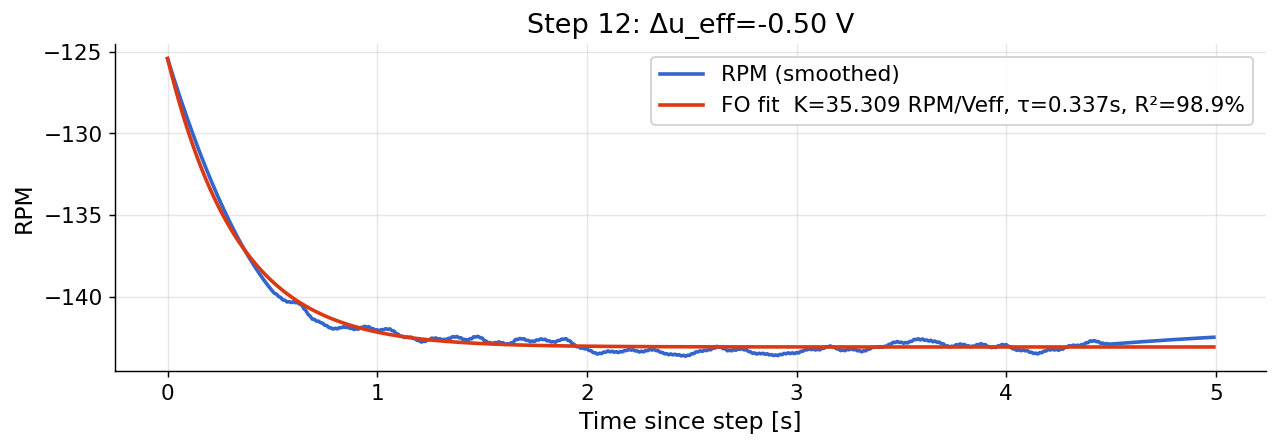

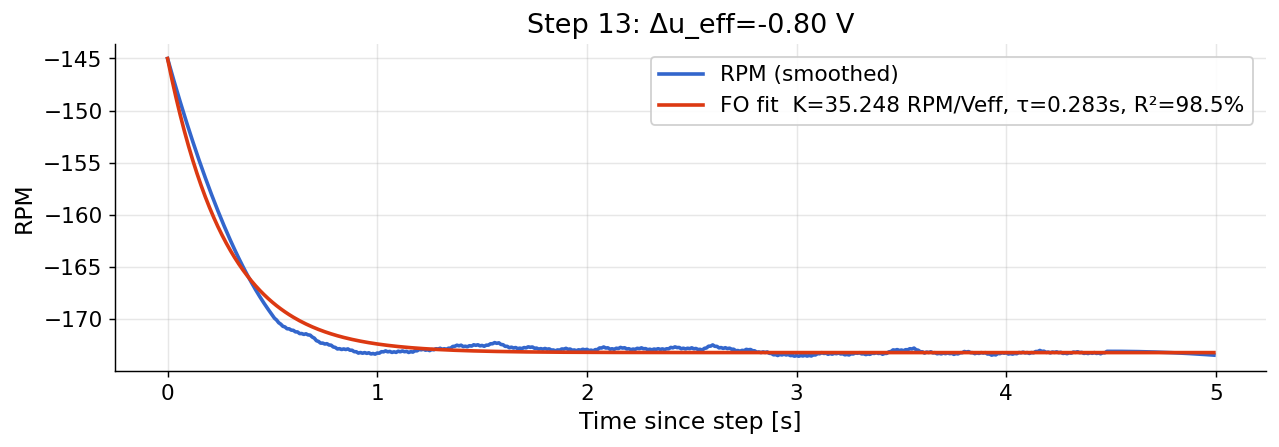

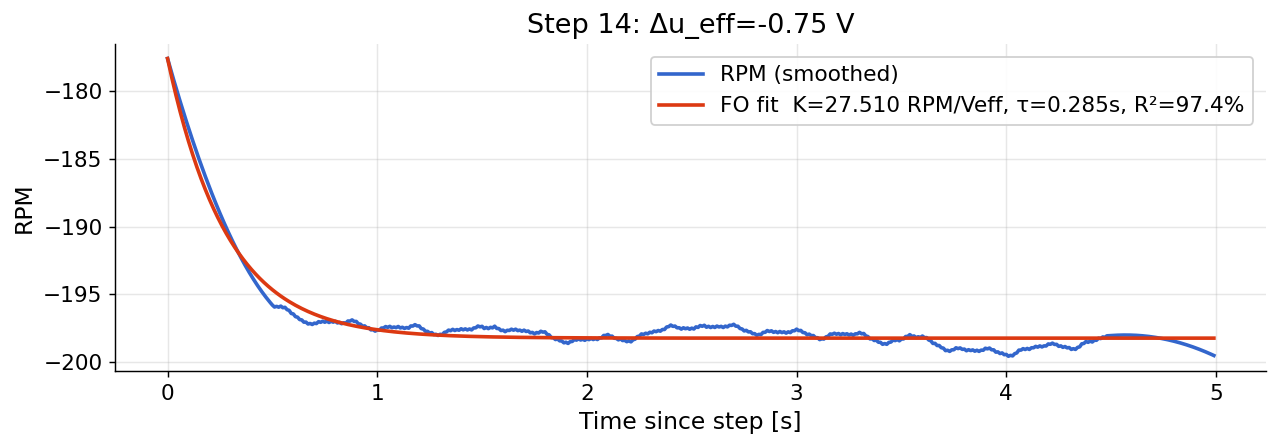

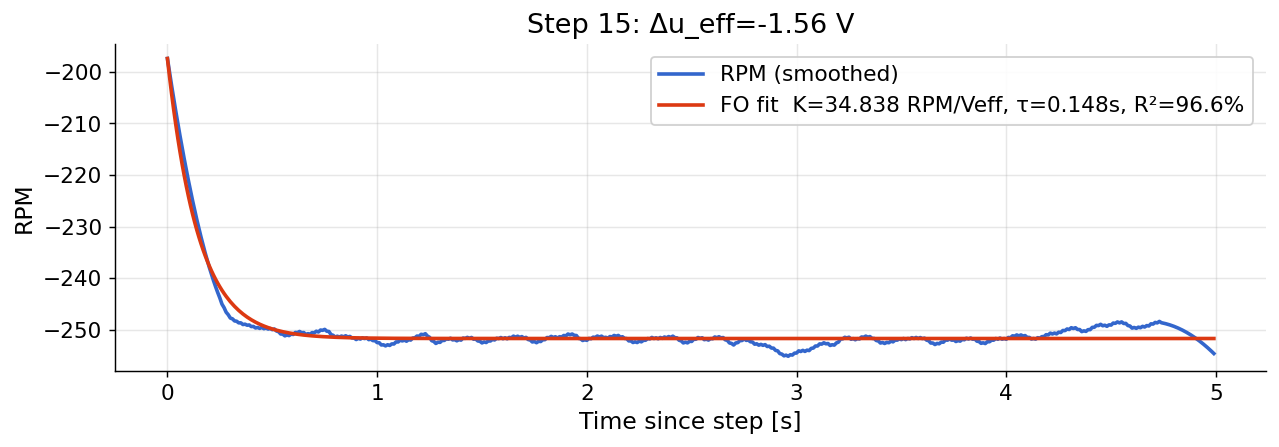

Per-step figures saved → /content/drive/MyDrive/Master_Archive/60_Academics/Projects/Thesis/steps
Per-step fit table (rounded)


,step_num,start_time,start_idx,end_idx,u_before,u_after,delta_u,delta_u_eff,y0,y_ss,delta_y_fit,K,tau,R2,MAE_RPM,direction,win_len
0,1,5.0,500,999,0.00,3.56,3.56,0.06,-4.647,60.934,62.190,1036.508,0.392,0.961,1.880,up,51
1,2,10.0,1000,1499,3.56,4.15,0.59,0.59,59.263,77.026,19.360,32.814,0.576,0.945,0.780,up,101
2,3,25.0,2500,2999,4.62,5.20,0.58,0.58,99.152,108.818,10.292,17.744,0.279,0.961,0.295,up,101
3,4,30.0,3000,3499,5.20,5.70,0.50,0.50,109.477,130.966,20.158,40.316,0.368,0.987,0.344,up,101
4,5,35.0,3500,3999,5.70,6.50,0.80,0.80,130.096,162.185,30.594,38.242,0.300,0.983,0.577,up,101
5,6,40.0,4000,4499,6.50,7.25,0.75,0.75,162.740,189.012,24.939,33.252,0.300,0.977,0.527,up,101
6,7,45.0,4500,4999,7.25,8.81,1.56,1.56,186.456,243.567,54.877,35.178,0.149,0.979,0.782,up,51
7,8,50.0,5000,5999,8.81,0.00,-8.81,-5.31,252.388,0.000,-253.180,47.680,0.276,0.967,2.419,down,51
8,9,60.0,6000,6499,0.00,-3.56,-3.56,-0.06,2.432,-77.091,-75.471,1257.847,0.417,0.967,2.206,down,51
9,10,65.0,6500,6999,-3.56,-4.15,-0.59,-0.59,-75.937,-93.206,-18.333,31.072,0.366,0.990,0.284,down,101


Candidates: ['Step1', 'Step2', 'Step3', 'Step4', 'Step5', 'Step6', 'Step7', 'Step8', 'Step9', 'Step10', 'Step11', 'Step12', 'Step13', 'Step14', 'Step15', 'Overall', 'Up_avg', 'Down_avg']


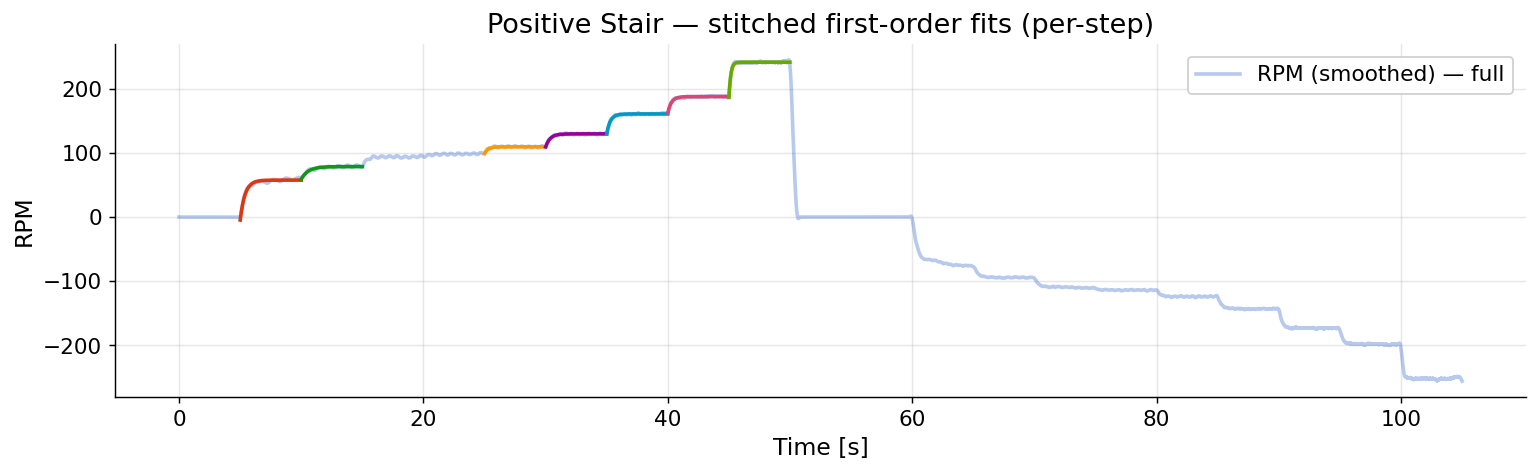

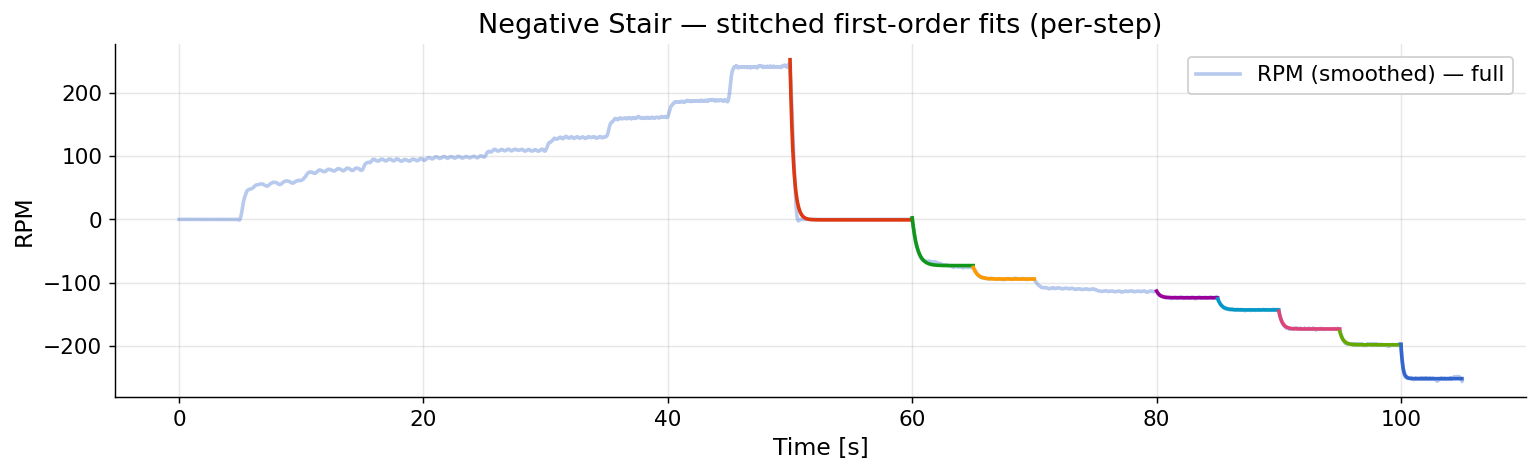

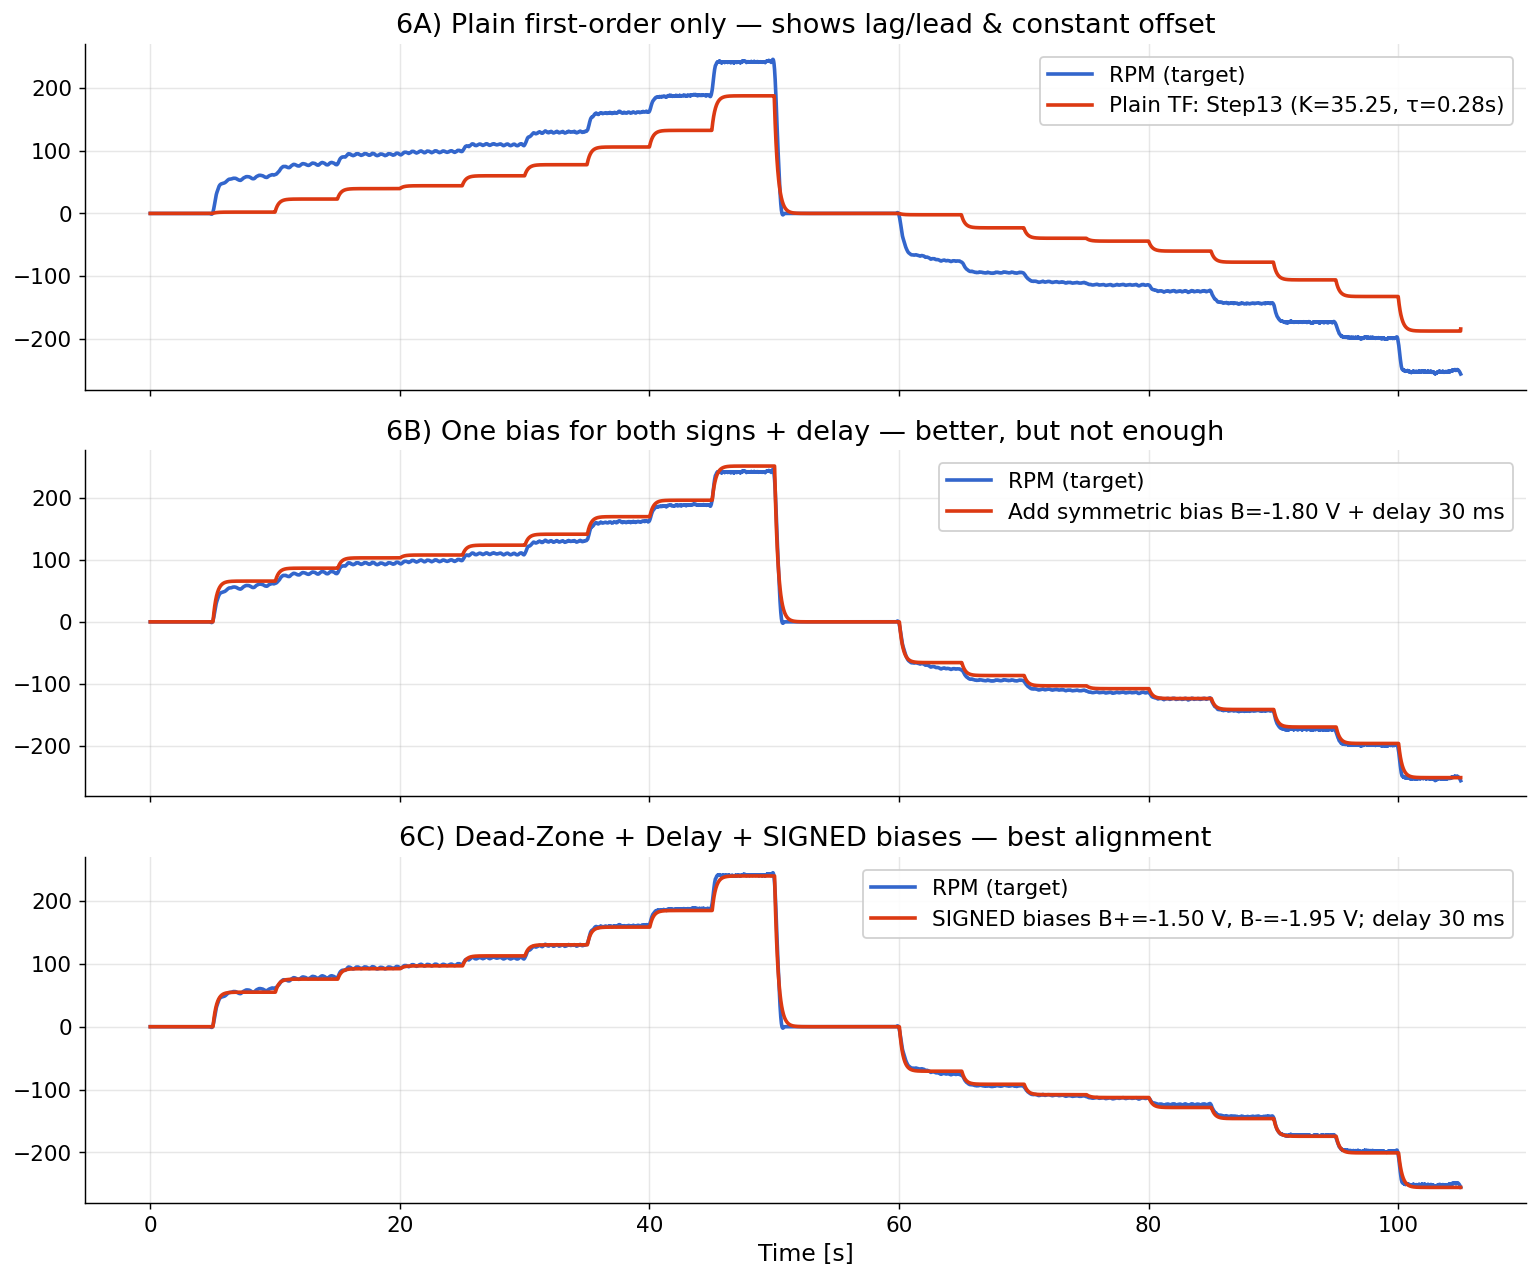

Section 6 MAE — plain: 52.01  |  sym: 6.16  |  signed: 2.32
Cross-validation (signed bias + delay):
Saved CV scores → /content/drive/MyDrive/Master_Archive/60_Academics/Projects/Thesis/cross_val_scores.csv
SECTION 7 — CV scores (sorted by Combined MAE, lower is better)


,Candidate,K,tau,U_bias_pos (V),U_bias_neg (V),T_delay (s),Overall MAE (RPM),Per-step MAE mean (RPM),Combined MAE (RPM)
0,Step13,35.248,0.283,-1.550,-1.950,0.031,2.209,16.202,9.205
1,Step12,35.309,0.337,-1.550,-1.950,0.012,2.287,16.290,9.288
2,Step15,34.838,0.148,-1.550,-1.950,0.100,2.225,16.363,9.294
3,Step7,35.178,0.149,-1.550,-1.950,0.100,2.284,16.306,9.295
4,Step6,33.252,0.300,-1.725,-2.175,0.042,2.622,17.098,9.860
5,Step5,38.242,0.300,-1.250,-1.575,0.012,4.289,16.242,10.266
6,Step2,32.814,0.576,-1.800,-2.275,0.000,3.725,18.229,10.977
7,Step4,40.316,0.368,-1.025,-1.400,0.000,6.396,16.512,11.454
8,Step10,31.072,0.366,-1.950,-2.425,0.021,4.460,18.659,11.560
9,Step14,27.510,0.285,-2.350,-2.900,0.071,7.838,21.023,14.430


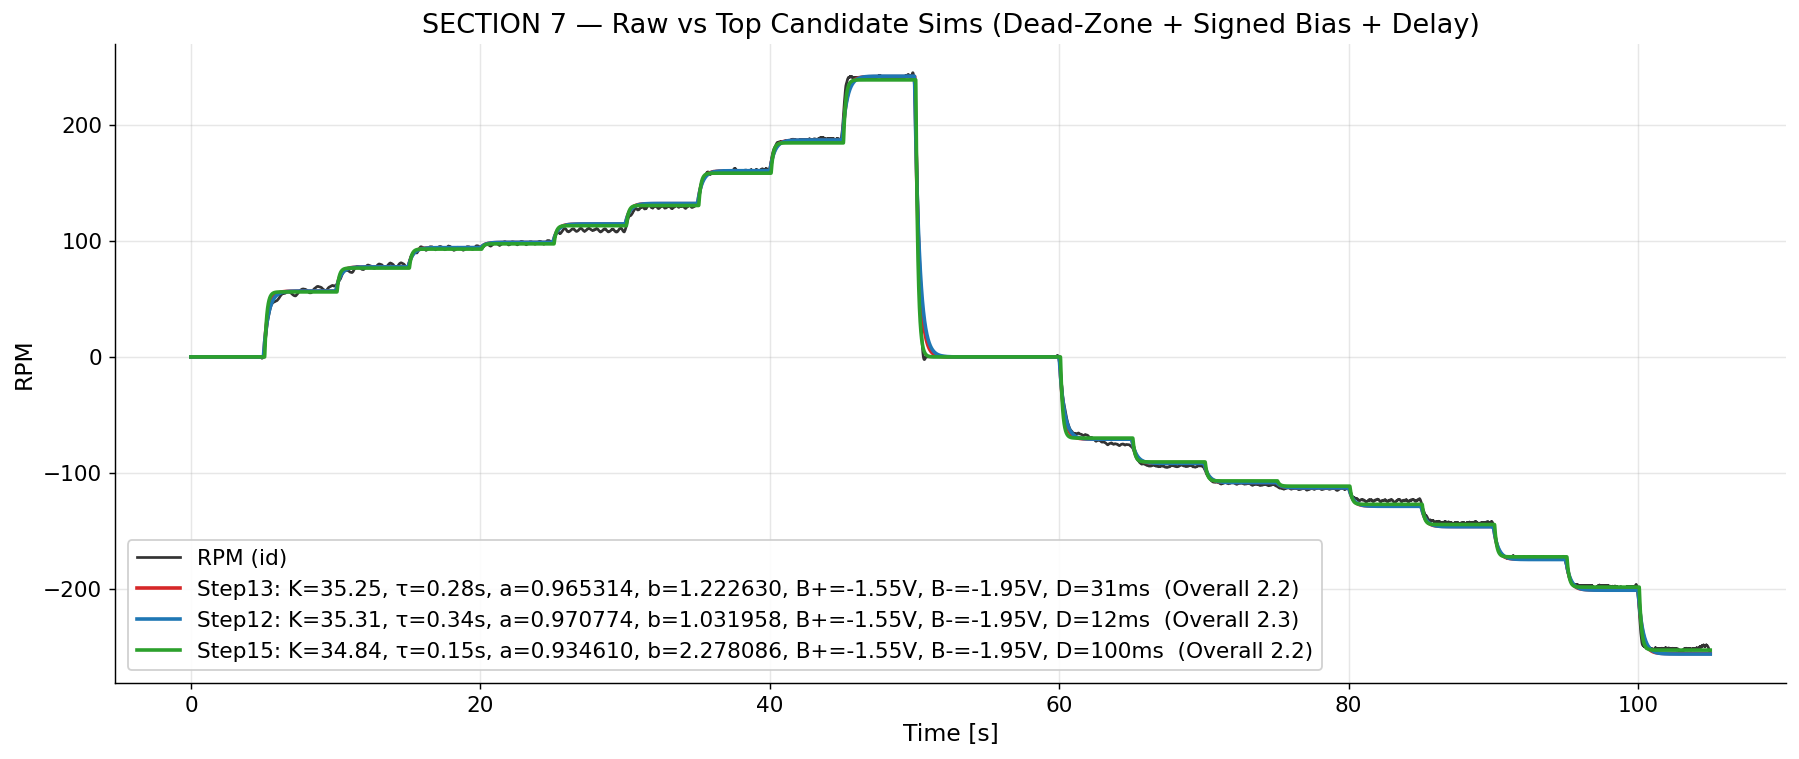

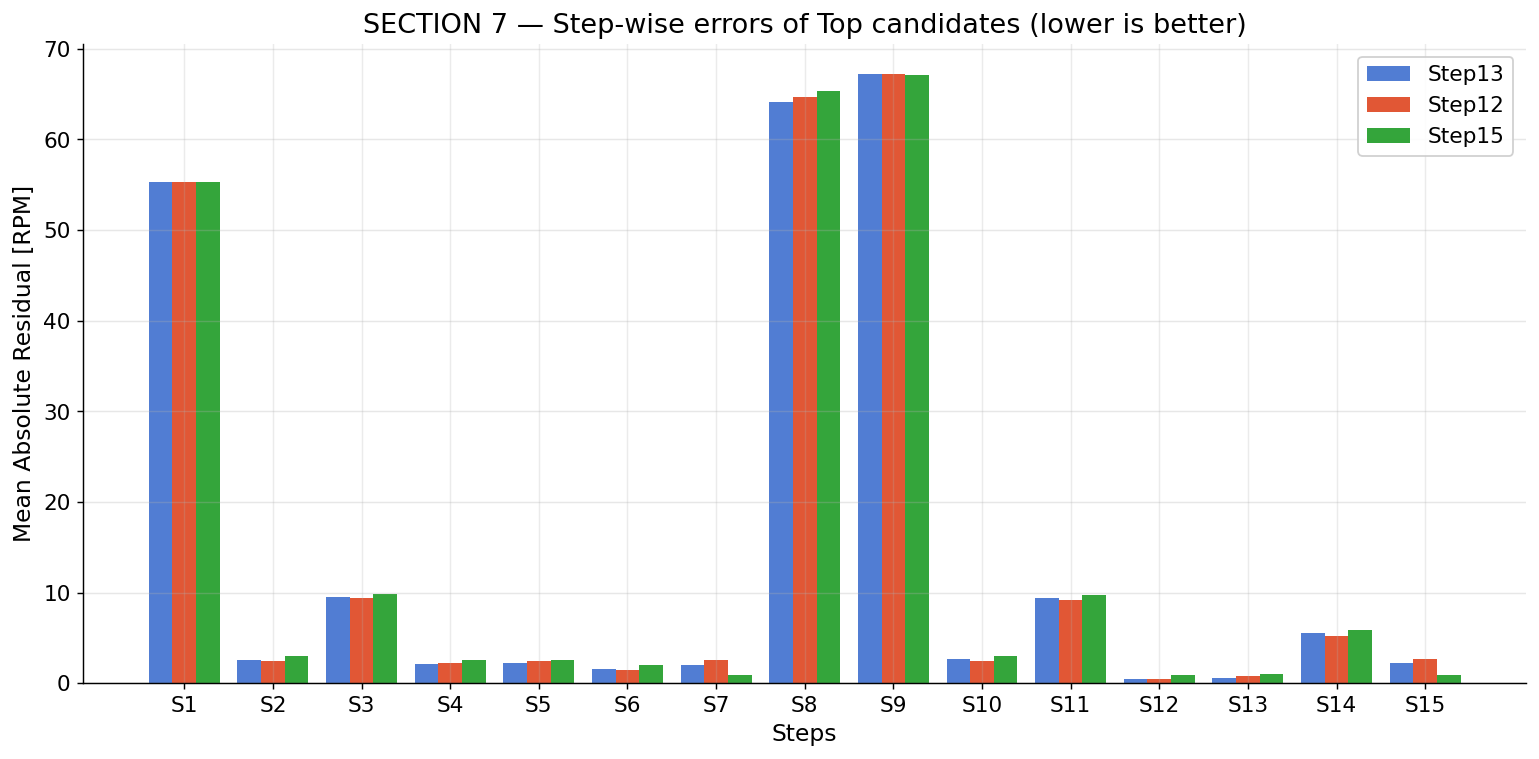

Final plant (selected):
  Dead-Zone: +3.50 V / -3.50 V (alpha=0.00)
  Signed bias: B+=-1.550 V, B-=-1.950 V
  Delay: 31 ms
  G(s) = 35.248 / (0.283 s + 1)


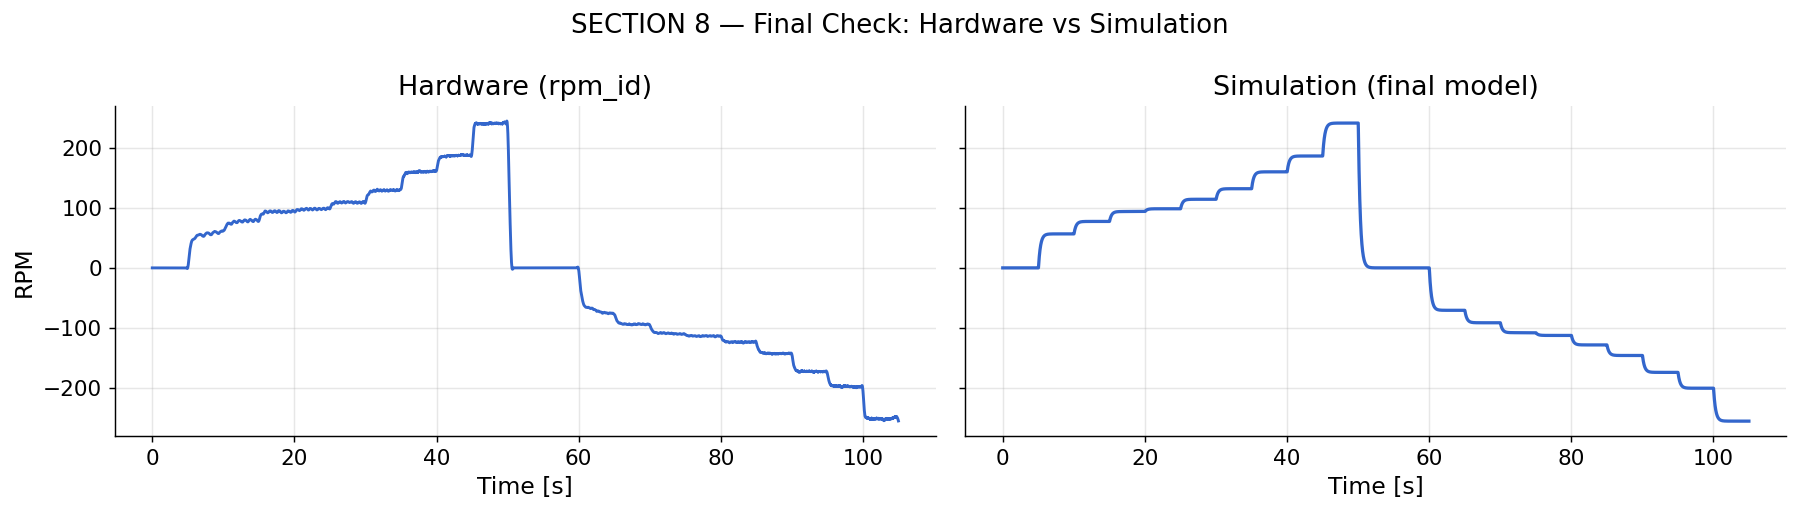

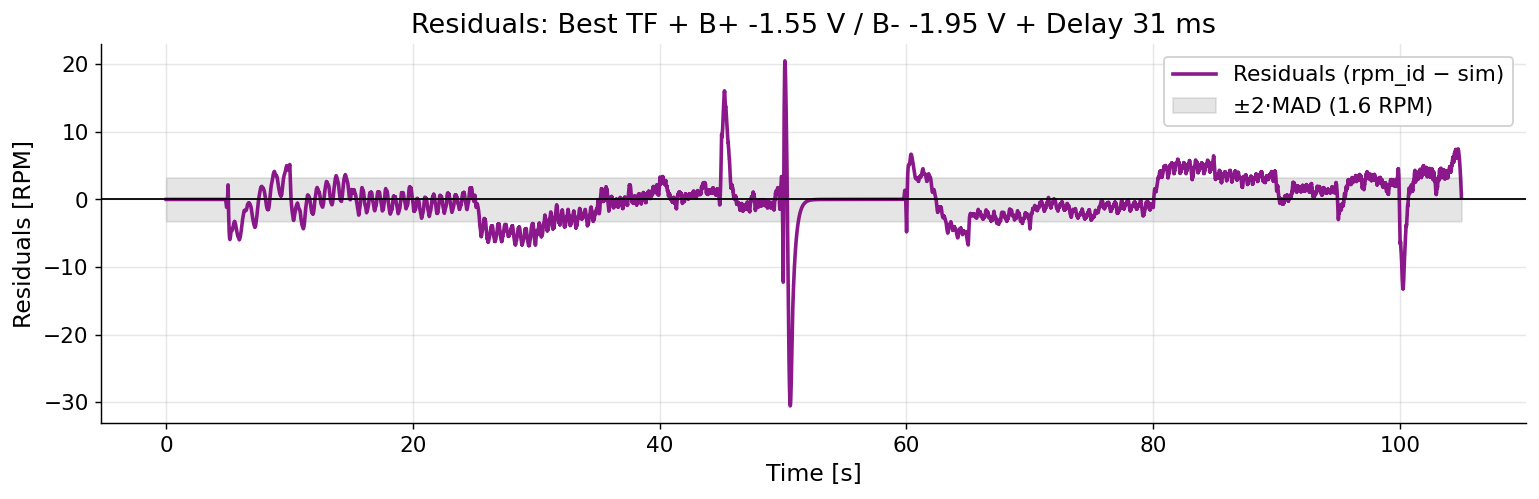

Final plant (selected):
  Dead-Zone: +3.50 V / -3.50 V (alpha=0.00)
  Signed bias: B+=-1.550 V, B-=-1.950 V
  Delay: 31 ms  (d=D/Ts=3.125 → n=3 + frac=0.125)
  Fractional delay FIR: uD = 0.875·z^(-3) + 0.125·z^(-4)
  G(s) = 35.248 / (0.283 s + 1)
  ZOH discrete @ Ts=0.0100s → a=0.965313633, b=1.222629831
Simulink wiring reminder: pos/neg derived from delayed RAW voltage; plant input is delayed u_eff; gains are (pos)=−B⁺, (neg)=+B⁻.
Artifacts saved: step_fits.csv, steps/*.png, cross_val_scores.csv, full_overlays_top3.png, final_residuals.png


In [ ]:
# ===============================================
# DC Motor System ID — Sections 3–8: Load → Steps → Fits → CV → Final
# ===============================================

# --- SECTION 4: Load CSV & Preprocessing ---
_df = pd.read_csv(CSV_PATH)
colmap = {'time':'time','time [s]':'time','voltage':'voltage','voltage [V] (u_raw)':'voltage','rpm':'rpm','rpm [RPM]':'rpm'}
ren = {c: colmap[c] for c in _df.columns if c in colmap and c != colmap[c]}
df = _df.rename(columns=ren).copy()
for c in ['time','voltage','rpm']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

_t = df['time'].to_numpy()
Ts = float(np.median(np.diff(_t))) if len(df) > 1 else 0.01
Ts = max(Ts, 1e-3)

# Fixed dead-zone
VDB_POS, VDB_NEG, SOFT_ALPHA = float(VDB_POS_DEFAULT), float(VDB_NEG_DEFAULT), 0.00

def deadzone_map(u):
    u = np.asarray(u, float)
    vdb = np.where(u >= 0.0, VDB_POS, VDB_NEG)
    mag = np.abs(u)
    eff_mag = np.where(mag <= vdb, SOFT_ALPHA*mag, (mag - vdb) + SOFT_ALPHA*vdb)
    return np.sign(u) * eff_mag

df['u_eff'] = deadzone_map(df['voltage'].to_numpy())

y_raw = df['rpm'].to_numpy()
base_win = int(round(0.5 / Ts)); base_win += (base_win % 2 == 0)
base_win = max(5, min(base_win, len(df) - (len(df) % 2 == 0)))
y_id = y_raw.copy() if base_win >= len(df) else savgol_filter(y_raw, window_length=base_win, polyorder=2, mode='interp')
df['rpm_id'] = y_id

print(f"Loaded {len(df)} samples @ Ts≈{Ts:.4f}s from: {CSV_PATH}")

# Visualization
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), sharex=True)
ax1.plot(df['time'], df['voltage'], label='u_raw [V]')
ax1.plot(df['time'], df['u_eff'],   label='u_eff [V] (after Dead-Zone)')
ax1.axhline(0, color='k', lw=0.8)
ax1.set_ylabel('Voltage [V]'); ax1.legend(); ax1.grid(True, alpha=0.3)
ax2.plot(df['time'], y_raw, label='RPM (raw)', alpha=0.65)
ax2.plot(df['time'], y_id,  label='RPM (smoothed)')
ax2.set_xlabel('Time [s]'); ax2.set_ylabel('RPM'); ax2.legend(); ax2.grid(True, alpha=0.3)
fig.suptitle('SECTION 4 — Dead-Zone + Smoothed RPM'); plt.tight_layout(); plt.show()


# --- SECTION 5: Step Detection & Per-Step Fits ---
thrV = max(0.2, 4.0 * stats.median_abs_deviation(np.diff(df['voltage'].to_numpy()), scale='normal'))
changes = [0] + [i for i in range(1, len(df)) if abs(df['voltage'].iloc[i] - df['voltage'].iloc[i-1]) >= thrV] + [len(df)]
MIN_DV = 0.5; MIN_DWELLN = int(2.0 / Ts)

def step_model(t, dy, tau):
    return dy * (1.0 - np.exp(-t / tau))

def _savgol_len(n, prefer):
    w = min(prefer, n if (n % 2 == 1) else (n - 1))
    if w < 5: w = 5
    if w % 2 == 0: w += 1
    return w

def r2_score(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    ss_res = np.sum((y - yhat)**2); ss_tot = np.sum((y - np.mean(y))**2)
    return 1.0 - (ss_res / ss_tot if ss_tot > 0 else np.inf)

step_results, diagnostics = [], []

# Visualize detected boundaries
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), sharex=True)
ax1.plot(df['time'], df['voltage'], label='u_raw [V]')
ax1.plot(df['time'], df['u_eff'],   label='u_eff [V]')
for k in range(1, len(changes)-1):
    ax1.axvline(df['time'].iloc[changes[k]], color='r', ls='--', alpha=0.35)
ax1.set_ylabel('Voltage [V]'); ax1.grid(True, alpha=0.3); ax1.legend()
ax2.plot(df['time'], y_raw, label='RPM (raw)', color='tab:green', alpha=0.8)
ax2.set_xlabel('Time [s]'); ax2.set_ylabel('RPM'); ax2.grid(True, alpha=0.3); ax2.legend()
fig.suptitle('SECTION 5 — Detected Change Boundaries'); plt.tight_layout(); plt.show()

# Per-step loop
prev_u = float(df['voltage'].iloc[0])
for seg in range(len(changes)-1):
    s = changes[seg]; e = changes[seg+1]-1
    if s > e: continue
    seg_df = df.iloc[s:e+1].copy()
    t0 = float(seg_df['time'].iloc[0])
    t_seg = seg_df['time'] - t0
    u_after = float(seg_df['voltage'].iloc[0])
    u_before= float(prev_u)
    du_raw = u_after - u_before
    if len(seg_df) < MIN_DWELLN: prev_u = u_after; continue
    if abs(du_raw) < MIN_DV:     prev_u = u_after; continue

    raw_seg = y_raw[s:e+1]
    prefer  = 101 if abs(du_raw) < 1.0 else 51
    win_len = _savgol_len(len(raw_seg), prefer)
    y_f = savgol_filter(raw_seg, window_length=win_len, polyorder=2, mode='interp')

    y0, yss = float(y_f[0]), float(y_f[-1])
    dy_guess = yss - y0
    if abs(dy_guess) < 5: prev_u = u_after; continue

    tau0 = np.clip((seg_df['time'].iloc[-1]-seg_df['time'].iloc[0])/3.0, 0.05, 2.0)
    p0 = [dy_guess, tau0]
    lb_tau, ub_tau = 0.02, 5.0
    if dy_guess >= 0: lb_dy, ub_dy = 0.3*dy_guess, 1.7*dy_guess
    else:             lb_dy, ub_dy = 1.7*dy_guess, 0.3*dy_guess

    du_eff = float(deadzone_map([u_after])[0] - deadzone_map([u_before])[0])

    try:
        popt, _ = curve_fit(step_model, t_seg.to_numpy(), y_f - y0,
                            p0=p0, bounds=([lb_dy, lb_tau],[ub_dy, ub_tau]), maxfev=10000)
        dy_fit, tau_fit = float(popt[0]), float(popt[1])
    except Exception:
        prev_u = u_after; continue

    y_hat = y0 + step_model(t_seg.to_numpy(), dy_fit, tau_fit)
    mae = float(np.mean(np.abs(y_f - y_hat)))
    r2  = float(r2_score(y_f, y_hat))
    K_fit = float(dy_fit/du_eff) if abs(du_eff) > 1e-6 else np.nan

    step_results.append({
        'step_num': len(step_results)+1,
        'start_time': t0, 'start_idx': int(s), 'end_idx': int(e),
        'u_before': u_before, 'u_after': u_after,
        'delta_u': du_raw, 'delta_u_eff': du_eff,
        'y0': y0, 'y_ss': yss, 'delta_y_fit': dy_fit,
        'K': K_fit, 'tau': tau_fit, 'R2': r2, 'MAE_RPM': mae,
        'direction': seg_df['direction'].iloc[0] if 'direction' in seg_df.columns else ('up' if du_raw>=0 else 'down'),
        'win_len': int(win_len)
    })

    diagnostics.append({
        'step_num': step_results[-1]['step_num'],
        't_win': t_seg.to_numpy(),
        'y_win_filt': y_f.astype(float),
        'y_win_fit': y_hat.astype(float),
        'du_eff': du_eff,
        'K': K_fit, 'tau': tau_fit, 'R2': r2
    })

    prev_u = u_after

assert len(step_results) > 0, 'No valid steps found. Adjust thresholds or verify input.'

step_fits_df = pd.DataFrame(step_results)
step_fits_df.to_csv(os.path.join(OUT_DIR,'step_fits.csv'), index=False)
print('Saved per-step fits →', os.path.join(OUT_DIR,'step_fits.csv'))

# Per-step diagnostics plots — RPM (smoothed) vs FO fit ONLY
MAX_SHOW = 24
for d in diagnostics:
    k = d['step_num']
    fig, ax = plt.subplots(1,1, figsize=(10,3.6))
    ax.plot(d['t_win'], d['y_win_filt'], label='RPM (smoothed)')
    ax.plot(d['t_win'], d['y_win_fit'],  label=f"FO fit  K={d['K']:.3f} RPM/Veff, τ={d['tau']:.3f}s, R²={d['R2']*100:.1f}%")
    ax.set_xlabel('Time since step [s]'); ax.set_ylabel('RPM'); ax.grid(True, alpha=0.3); ax.legend()
    ax.set_title(f"Step {k}: Δu_eff={d['du_eff']:.2f} V")
    out_png = os.path.join(STEP_PLOTS_DIR, f'step_{k:02d}.png')
    plt.tight_layout(); plt.savefig(out_png, dpi=150)
    (plt.show() if k <= MAX_SHOW else plt.close(fig))
print('Per-step figures saved →', STEP_PLOTS_DIR)
show_table(step_fits_df.round(3), caption='Per-step fit table (rounded)')

# Aggregate candidates
valid = [r for r in step_results if not np.isnan(r['K'])]
K_all = [r['K'] for r in valid]; tau_all = [r['tau'] for r in valid]
overall_K, overall_tau = float(np.mean(K_all)), float(np.mean(tau_all))

def _dir(r):
    if isinstance(r['direction'], str):
        return r['direction'].strip().lower()
    return ('up' if r['direction']>=0 else 'down')

up = [r for r in valid if _dir(r)=='up']; down = [r for r in valid if _dir(r)=='down']
up_K = float(np.mean([r['K'] for r in up])) if up else np.nan
up_tau = float(np.mean([r['tau'] for r in up])) if up else np.nan
dn_K = float(np.mean([r['K'] for r in down])) if down else np.nan
dn_tau = float(np.mean([r['tau'] for r in down])) if down else np.nan

candidates = [{'name':f"Step{r['step_num']}", 'K':float(r['K']), 'tau':float(r['tau'])} for r in valid]
candidates += [{'name':'Overall','K':overall_K,'tau':overall_tau}]
if not np.isnan(up_K):   candidates += [{'name':'Up_avg','K':up_K,'tau':up_tau}]
if not np.isnan(dn_K):   candidates += [{'name':'Down_avg','K':dn_K,'tau':dn_tau}]
print('Candidates:', [c['name'] for c in candidates])

# --- 5A: Stitched Positive / Negative stair plots (RPM smoothed + per-step FO fits)
def _steps_by_sign(steps):
    pos, neg = [], []
    for st in steps:
        (pos if st['delta_u_eff']>0 else neg).append(st)
    return pos, neg

def _stitched_group_plot(steps, label):
    fig, ax = plt.subplots(figsize=(12,3.8))
    ax.plot(df['time'], df['rpm_id'], alpha=0.35, label='RPM (smoothed) — full')
    for st in steps:
        s, e = int(st['start_idx']), int(st['end_idx'])
        t_seg  = df['time'].iloc[s:e+1].to_numpy() - df['time'].iloc[s]
        y_fit  = st['y0'] + step_model(t_seg, st['delta_y_fit'], st['tau'])
        ax.plot(df['time'].iloc[s:e+1], y_fit, lw=2)
    ax.set_title(f'{label} Stair — stitched first-order fits (per-step)')
    ax.set_xlabel('Time [s]'); ax.set_ylabel('RPM'); ax.grid(alpha=0.3); ax.legend(loc='best')
    plt.tight_layout(); plt.show()

_pos, _neg = _steps_by_sign(step_results)
if _pos: _stitched_group_plot(_pos, 'Positive')
if _neg: _stitched_group_plot(_neg, 'Negative')


# --- SECTION 6: Simulation Helpers + Story Plots (Plain TF → Sym bias+delay → Signed bias+delay) ---

def apply_delay(u, t, Td):
    if Td <= 1e-9:
        return np.asarray(u, float).copy()
    t = np.asarray(t, float); u = np.asarray(u, float)
    # true delay: output at time t uses input from t - Td
    return np.interp(t - float(Td), t, u, left=u[0], right=u[-1])

def sim_full_response(K, tau, u_input, t_input):
    sys = TransferFunction([K], [tau, 1.0])
    _, yout, _ = lsim(sys, U=u_input, T=t_input, X0=0.0)
    return yout

# ***** sign path from RAW voltage (after the same delay), plant path from u_eff *****
def sim_full_signed_bias(K, tau, u_eff, t, Bpos, Bneg, D, u_sign=None):
    """
    u_eff: dead-zoned input (voltage after dead-zone map)
    u_sign: raw voltage (pre dead-zone) for sign detection; if None, fall back to u_eff
    """
    uD_eff  = apply_delay(u_eff, t, D)
    sign_src = u_eff if (u_sign is None) else np.asarray(u_sign, float)
    uD_sign = apply_delay(sign_src, t, D)
    pos = (uD_sign > 0).astype(float); neg = (uD_sign < 0).astype(float)
    y_u   = sim_full_response(K, tau, uD_eff,  t)
    y_pos = sim_full_response(K, tau, pos,    t)
    y_neg = sim_full_response(K, tau, neg,    t)
    # Model: ŷ = y_u − B⁺·y_pos + B⁻·y_neg
    return y_u - Bpos*y_pos + Bneg*y_neg

def fit_signed_bias_delay_fast(K, tau, u_eff, t, y_true, mask,
                               bias_pos_bounds=(-5.0,5.0), bias_neg_bounds=(-5.0,5.0),
                               delay_bounds=(0.0,0.30), coarse_B_n=17, coarse_D_n=19,
                               fine_B_n=9, fine_D_n=9, u_sign=None):
    idx = np.where(mask)[0]
    best = {'Bpos':0.0,'Bneg':0.0,'D':0.0,'mae':np.inf}
    Bs_pos = np.linspace(*bias_pos_bounds, coarse_B_n)
    Bs_neg = np.linspace(*bias_neg_bounds, coarse_B_n)
    Ds     = np.linspace(*delay_bounds,    coarse_D_n)
    for D in Ds:
        y_uD = sim_full_signed_bias(K, tau, u_eff, t, 0.0, 0.0, D, u_sign=u_sign)  # base with delay only
        # build sign responses once per D
        sign_src = u_eff if (u_sign is None) else np.asarray(u_sign, float)
        uD_sign = apply_delay(sign_src, t, D)
        pos = (uD_sign > 0).astype(float); neg = (uD_sign < 0).astype(float)
        y_pos = sim_full_response(K, tau, pos, t)
        y_neg = sim_full_response(K, tau, neg, t)
        yu, yp, yn, yt = y_uD[idx], y_pos[idx], y_neg[idx], y_true[idx]
        for Bp in Bs_pos:
            base = yu - Bp*yp
            yhat = base[:,None] + yn[:,None]*Bs_neg[None,:]
            mae_vec = np.mean(np.abs(yt[:,None] - yhat), axis=0)
            j = int(np.argmin(mae_vec)); mae = float(mae_vec[j])
            if mae < best['mae']:
                best.update({'Bpos':float(Bp),'Bneg':float(Bs_neg[j]),'D':float(D),'mae':mae})
    # local refine
    Bp0, Bn0, D0 = best['Bpos'], best['Bneg'], best['D']
    Bs_pos_f = np.linspace(Bp0-0.30, Bp0+0.30, fine_B_n)
    Bs_neg_f = np.linspace(Bn0-0.30, Bn0+0.30, fine_B_n)
    Ds_f     = np.linspace(max(delay_bounds[0], D0-0.05), min(delay_bounds[1], D0+0.05), fine_D_n)
    for D in Ds_f:
        y_uD = sim_full_signed_bias(K, tau, u_eff, t, 0.0, 0.0, D, u_sign=u_sign)
        sign_src = u_eff if (u_sign is None) else np.asarray(u_sign, float)
        uD_sign = apply_delay(sign_src, t, D)
        pos = (uD_sign > 0).astype(float); neg = (uD_sign < 0).astype(float)
        y_pos = sim_full_response(K, tau, pos, t)
        y_neg = sim_full_response(K, tau, neg, t)
        yu, yp, yn, yt = y_uD[idx], y_pos[idx], y_neg[idx], y_true[idx]
        for Bp in Bs_pos_f:
            base = yu - Bp*yp
            yhat = base[:,None] + yn[:,None]*Bs_neg_f[None,:]
            mae_vec = np.mean(np.abs(yt[:,None] - yhat), axis=0)
            j = int(np.argmin(mae_vec)); mae = float(mae_vec[j])
            if mae < best['mae']:
                best.update({'Bpos':float(Bp),'Bneg':float(Bs_neg_f[j]),'D':float(D),'mae':mae})
    return best['Bpos'], best['Bneg'], best['D'], best['mae']

# Symmetric bias+delay
def fit_symmetric_bias_delay(K, tau, u_eff, t, y_true,
                             B_bounds=(-3,3), nB=25, D_bounds=(0,0.06), nD=13, u_sign=None):
    Bs = np.linspace(*B_bounds, nB)
    Ds = np.linspace(*D_bounds, nD)
    best={'B':0.0,'D':0.0,'mae':np.inf}
    sign_src = u_eff if (u_sign is None) else np.asarray(u_sign, float)
    for D in Ds:
        uD_eff  = apply_delay(u_eff,  t, D)
        uD_sign = apply_delay(sign_src, t, D)
        pos=(uD_sign>0).astype(float); neg=(uD_sign<0).astype(float)
        y_u   = sim_full_response(K, tau, uD_eff, t)
        y_pos = sim_full_response(K, tau, pos,    t)
        y_neg = sim_full_response(K, tau, neg,    t)
        Yhat  = (y_u[:,None] - y_pos[:,None]*Bs[None,:] + y_neg[:,None]*Bs[None,:])
        mae_vec = np.mean(np.abs(y_true[:,None]-Yhat), axis=0)
        j = int(np.argmin(mae_vec)); mae=float(mae_vec[j])
        if mae < best['mae']:
            best.update({'B':float(Bs[j]), 'D':float(D), 'mae':mae})
    return best['B'], best['D'], best['mae']

def zoh_ab(K, tau, Ts):
    a = float(np.exp(-Ts / max(tau, 1e-12)))
    b = float(K * (1.0 - a))
    return a, b

def frac_delay_coeffs(D, Ts):
    d = float(D / max(Ts, 1e-12))
    n = int(np.floor(d))
    f = d - n
    w0, w1 = (1.0 - f), f           # uD = w0*z^-n + w1*z^-(n+1)
    return n, f, w0, w1

# === Section 6 Story Plots ===
t_full      = df['time'].to_numpy()
u_eff_full  = df['u_eff'].to_numpy()
u_raw_full  = df['voltage'].to_numpy()
y_target    = df['rpm_id'].to_numpy()

# Choose ONE "plain TF" to illustrate offset/lag
def per_step_mae_no_bias_delay(K, tau):
    maes=[]
    for r in step_results:
        s, e = int(r['start_idx']), int(r['end_idx'])
        t_seg = df['time'].iloc[s:e+1].to_numpy() - df['time'].iloc[s]
        y_meas = df['rpm_id'].iloc[s:e+1].to_numpy()
        y_fit  = r['y0'] + step_model(t_seg, r['delta_u_eff']*K, tau)
        maes.append(float(np.mean(np.abs(y_meas - y_fit))))
    return float(np.mean(maes))

plain_scores=[(c['name'], c['K'], c['tau'], per_step_mae_no_bias_delay(c['K'], c['tau'])) for c in candidates]
plain_scores = sorted(plain_scores, key=lambda z: z[3])
PLAIN_NAME, K_PLAIN, TAU_PLAIN, _ = plain_scores[0]

y_plain = sim_full_response(K_PLAIN, TAU_PLAIN, u_eff_full, t_full)  # no bias, no delay

# Symmetric bias+delay then signed bias+delay using RAW for sign
B_same, D_sym, mae_sym = fit_symmetric_bias_delay(K_PLAIN, TAU_PLAIN, u_eff_full, t_full, y_target,
                                                  B_bounds=(-3,3), nB=21, D_bounds=(0,0.06), nD=13,
                                                  u_sign=u_raw_full)
y_sym = sim_full_signed_bias(K_PLAIN, TAU_PLAIN, u_eff_full, t_full, B_same, B_same, D_sym, u_sign=u_raw_full)

Bp_sgn, Bn_sgn, D_sgn, mae_sgn = fit_signed_bias_delay_fast(
    K_PLAIN, TAU_PLAIN, u_eff_full, t_full, y_target, np.ones_like(t_full, bool),
    bias_pos_bounds=(-3,3), bias_neg_bounds=(-3,3),
    delay_bounds=(0.0,0.06), coarse_B_n=17, coarse_D_n=13, fine_B_n=9, fine_D_n=9,
    u_sign=u_raw_full
)
y_sgn = sim_full_signed_bias(K_PLAIN, TAU_PLAIN, u_eff_full, t_full, Bp_sgn, Bn_sgn, D_sgn, u_sign=u_raw_full)

fig, axes = plt.subplots(3,1, figsize=(12,10), sharex=True)
axes[0].plot(t_full, y_target, label='RPM (target)')
axes[0].plot(t_full, y_plain,  label=f'Plain TF: {PLAIN_NAME} (K={K_PLAIN:.2f}, τ={TAU_PLAIN:.2f}s)')
axes[0].set_title('6A) Plain first-order only — shows lag/lead & constant offset'); axes[0].grid(alpha=0.3); axes[0].legend()

axes[1].plot(t_full, y_target, label='RPM (target)')
axes[1].plot(t_full, y_sym,    label=f'Add symmetric bias B={B_same:+.2f} V + delay {int(1e3*D_sym)} ms')
axes[1].set_title('6B) One bias for both signs + delay — better, but not enough'); axes[1].grid(alpha=0.3); axes[1].legend()

axes[2].plot(t_full, y_target, label='RPM (target)')
axes[2].plot(t_full, y_sgn,    label=f'SIGNED biases B+={Bp_sgn:+.2f} V, B-={Bn_sgn:+.2f} V; delay {int(1e3*D_sgn)} ms')
axes[2].set_title('6C) Dead-Zone + Delay + SIGNED biases — best alignment'); axes[2].grid(alpha=0.3); axes[2].legend()
axes[2].set_xlabel('Time [s]'); plt.tight_layout(); plt.show()

print(f"Section 6 MAE — plain: {np.mean(np.abs(y_target-y_plain)):.2f}  |  sym: {mae_sym:.2f}  |  signed: {mae_sgn:.2f}")


# =============================================================
# --- SECTION 7: Cross-Validation (Signed bias + delay), Scores + Overlays + Per-step bars
# =============================================================
CV_FROM = float(df['time'].min())
mask_full   = df['time'].to_numpy() >= CV_FROM
y_true_full = df['rpm_id'].to_numpy()
u_eff_full  = df['u_eff'].to_numpy()
u_raw_full  = df['voltage'].to_numpy()
t_full      = df['time'].to_numpy()

scores = []
print("Cross-validation (signed bias + delay):")
for cand in candidates:
    name, K, tau = cand['name'], float(cand['K']), float(cand['tau'])

    Bp, Bn, D, mae_overall = fit_signed_bias_delay_fast(
        K, tau, u_eff_full, t_full, y_true_full, mask_full,
        bias_pos_bounds=(-5, 5), bias_neg_bounds=(-5, 5),
        delay_bounds=(0.0, 0.30), coarse_B_n=17, coarse_D_n=19,
        fine_B_n=9, fine_D_n=9, u_sign=u_raw_full
    )

    # per-step MAE WITHOUT bias/delay
    maes = []
    for r in step_results:
        if name.startswith('Step') and int(name[4:]) == r['step_num']:
            continue
        s, e   = int(r['start_idx']), int(r['end_idx'])
        t_seg  = df['time'].iloc[s:e+1].to_numpy() - df['time'].iloc[s]
        y_meas = df['rpm_id'].iloc[s:e+1].to_numpy()
        y_sim  = r['y0'] + step_model(t_seg, r['delta_u_eff']*K, tau)
        maes.append(float(np.mean(np.abs(y_meas - y_sim))))

    avg_steps = float(np.mean(maes)) if len(maes)>0 else np.nan
    combined  = 0.5*mae_overall + 0.5*avg_steps if np.isfinite(avg_steps) else mae_overall

    scores.append({
        'Candidate': name, 'K': K, 'tau': tau,
        'U_bias_pos (V)': float(Bp), 'U_bias_neg (V)': float(Bn), 'T_delay (s)': float(D),
        'Overall MAE (RPM)': mae_overall, 'Per-step MAE mean (RPM)': avg_steps, 'Combined MAE (RPM)': combined
    })

scores_df = pd.DataFrame(scores).sort_values('Combined MAE (RPM)').reset_index(drop=True)
scores_csv = os.path.join(OUT_DIR, 'cross_val_scores.csv'); scores_df.round(3).to_csv(scores_csv, index=False)
print(f"Saved CV scores → {scores_csv}")
show_table(scores_df.round(3), caption='SECTION 7 — CV scores (sorted by Combined MAE, lower is better)')

# Top-N overlay
TOPN = min(3, len(scores_df))
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(df['time'], df['rpm_id'].to_numpy(), 'k-', alpha=0.8, label='RPM (id)', lw=1.5)

palette = ['tab:red','tab:blue','tab:green','tab:purple']
for i in range(TOPN):
    row = scores_df.iloc[i]
    K, tau = float(row['K']), float(row['tau'])
    Bp, Bn, D = float(row['U_bias_pos (V)']), float(row['U_bias_neg (V)']), float(row['T_delay (s)'])
    y_sim = sim_full_signed_bias(K, tau, u_eff_full, t_full, Bp, Bn, D, u_sign=u_raw_full)

    a_i, b_i = zoh_ab(K, tau, Ts)
    ax.plot(df['time'], y_sim, color=palette[i%len(palette)], lw=2,
            label=(f"{row['Candidate']}: K={K:.2f}, τ={tau:.2f}s, a={a_i:.6f}, b={b_i:.6f}, "
                   f"B+={Bp:+.2f}V, B-={Bn:+.2f}V, D={int(D*1e3)}ms  "
                   f"(Overall {row['Overall MAE (RPM)']:.1f})"))
ax.set_xlabel('Time [s]'); ax.set_ylabel('RPM')
ax.set_title('SECTION 7 — Raw vs Top Candidate Sims (Dead-Zone + Signed Bias + Delay)')
ax.grid(True, alpha=0.3); ax.legend(loc='best')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'full_overlays_top3.png'), dpi=150); plt.show()

# Per-step grouped bars (Top-N)
step_labels = [f"S{int(r['step_num'])}" for r in step_results]
mat, top_names = [], list(scores_df['Candidate'][:TOPN])
for nm in top_names:
    row = scores_df[scores_df["Candidate"]==nm].iloc[0]
    K, tau = float(row['K']), float(row['tau'])
    maes=[]
    for r in step_results:
        s, e = int(r['start_idx']), int(r['end_idx'])
        t_seg = df['time'].iloc[s:e+1].to_numpy() - df['time'].iloc[s]
        y_meas = df['rpm_id'].iloc[s:e+1].to_numpy()
        y_sim  = r['y0'] + step_model(t_seg, r['delta_u_eff']*K, tau)
        maes.append(float(np.mean(np.abs(y_meas - y_sim))))
    mat.append(maes)
mat = np.vstack(mat)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(step_labels)); width = 0.8/max(1,TOPN)
for k, nm in enumerate(top_names):
    ax.bar(x + k*width - (TOPN-1)*width/2, mat[k], width, label=nm, alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels(step_labels)
ax.set_ylabel('Mean Absolute Residual [RPM]'); ax.set_xlabel('Steps')
ax.set_title('SECTION 7 — Step-wise errors of Top candidates (lower is better)')
ax.grid(True, axis='y', alpha=0.3); ax.legend(loc='upper right')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, 'topN_grouped_step_MAE.png'), dpi=150); plt.show()

# Winner
winner = scores_df.iloc[0]
best_name = winner['Candidate']; best_K, best_tau = float(winner['K']), float(winner['tau'])
best_Bp, best_Bn, best_D = float(winner['U_bias_pos (V)']), float(winner['U_bias_neg (V)']), float(winner['T_delay (s)'])
print('Final plant (selected):')
print(f"  Dead-Zone: +{VDB_POS:.2f} V / -{VDB_NEG:.2f} V (alpha={SOFT_ALPHA:.2f})")
print(f"  Signed bias: B+={best_Bp:+.3f} V, B-={best_Bn:+.3f} V")
print(f"  Delay: {best_D*1e3:.0f} ms")
print(f"  G(s) = {best_K:.3f} / ({best_tau:.3f} s + 1)")

pd.DataFrame({'Best_Candidate':[best_name],'Best_K':[best_K],'Best_tau':[best_tau],
              'U_bias_pos_V':[best_Bp],'U_bias_neg_V':[best_Bn],'T_delay_s':[best_D],
              'DeadZone_PosV':[VDB_POS],'DeadZone_NegV':[VDB_NEG],'SoftAlpha':[SOFT_ALPHA],
              'TF_str':[f"{best_K:.3f} / ({best_tau:.3f} s + 1) with B+={best_Bp:+.3f} V, B-={best_Bn:+.3f} V, D={best_D:.3f} s"]
             }).to_csv(os.path.join(OUT_DIR,'recommended_tf_with_bias_delay.csv'), index=False)


# --- SECTION 8: Final Checks — Side-by-Side & Residuals, plus (a,b) for Simulink ---
def overlay_sim_response_signed(K, tau, u_eff, t, Bpos, Bneg, D, u_sign=None):
    return sim_full_signed_bias(K, tau, u_eff, t, Bpos, Bneg, D, u_sign=u_sign)

y_sim_final = overlay_sim_response_signed(best_K, best_tau, df['u_eff'].to_numpy(), df['time'].to_numpy(),
                                          best_Bp, best_Bn, best_D, u_sign=df['voltage'].to_numpy())

# Side-by-side
fig, axes = plt.subplots(1,2, figsize=(14,4), sharex=True, sharey=True)
axes[0].plot(df['time'], df['rpm_id'], lw=1.6)
axes[0].set_title("Hardware (rpm_id)"); axes[0].set_xlabel("Time [s]"); axes[0].set_ylabel("RPM"); axes[0].grid(alpha=0.3)
axes[1].plot(df['time'], y_sim_final, lw=1.8)
axes[1].set_title("Simulation (final model)"); axes[1].set_xlabel("Time [s]"); axes[1].grid(alpha=0.3)
plt.suptitle("SECTION 8 — Final Check: Hardware vs Simulation"); plt.tight_layout(); plt.show()

# Residuals vs rpm_id
resids = df['rpm_id'].to_numpy() - y_sim_final
mad = stats.median_abs_deviation(resids)
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df['time'], resids, color='purple', alpha=0.9, label='Residuals (rpm_id − sim)')
ax.axhline(0, color='k', lw=1)
ax.fill_between(df['time'], -2*mad, 2*mad, color='gray', alpha=0.2, label=f'±2·MAD ({mad:.1f} RPM)')
ax.set_xlabel('Time [s]'); ax.set_ylabel('Residuals [RPM]')
ax.set_title(f"Residuals: Best TF + B+ {best_Bp:+.2f} V / B- {best_Bn:+.2f} V + Delay {int(best_D*1e3)} ms")
ax.grid(True, alpha=0.3); ax.legend(loc='best')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'final_residuals.png'), dpi=150); plt.show()

# Discrete params for Simulink
a, b = zoh_ab(best_K, best_tau, Ts)
n, f, w0, w1 = frac_delay_coeffs(best_D, Ts)

pd.DataFrame({
    'Best_Candidate':[best_name],
    'Best_K':[best_K], 'Best_tau':[best_tau],
    'a':[a], 'b':[b],
    'U_bias_pos_V':[best_Bp], 'U_bias_neg_V':[best_Bn], 'T_delay_s':[best_D],
    'Delay_samples_total':[best_D/Ts], 'Delay_n_int':[n], 'Delay_frac':[f], 'Delay_w0':[w0], 'Delay_w1':[w1],
    'DeadZone_PosV':[VDB_POS], 'DeadZone_NegV':[VDB_NEG], 'SoftAlpha':[SOFT_ALPHA],
    'TF_str':[f"{best_K:.3f} / ({best_tau:.3f} s + 1) with a={a:.6f}, b={b:.6f}, B+={best_Bp:+.3f} V, B-={best_Bn:+.3f} V, D={best_D:.3f} s"]
}).to_csv(os.path.join(OUT_DIR,'recommended_tf_with_bias_delay.csv'), index=False)

print('Final plant (selected):')
print(f"  Dead-Zone: +{VDB_POS:.2f} V / -{VDB_NEG:.2f} V (alpha={SOFT_ALPHA:.2f})")
print(f"  Signed bias: B+={best_Bp:+.3f} V, B-={best_Bn:+.3f} V")
print(f"  Delay: {best_D*1e3:.0f} ms  (d=D/Ts={best_D/Ts:.3f} → n={n} + frac={f:.3f})")
print(f"  Fractional delay FIR: uD = {w0:.3f}·z^(-{n}) + {w1:.3f}·z^(-{n+1})")
print(f"  G(s) = {best_K:.3f} / ({best_tau:.3f} s + 1)")
print(f"  ZOH discrete @ Ts={Ts:.4f}s → a={a:.9f}, b={b:.9f}")
print("Simulink wiring reminder: pos/neg derived from delayed RAW voltage; plant input is delayed u_eff; gains are (pos)=−B⁺, (neg)=+B⁻.")
print('Artifacts saved: step_fits.csv, steps/*.png, cross_val_scores.csv, full_overlays_top3.png, final_residuals.png')

In [ ]:
# --- SECTION 9: Export LUT & Chebyshev params ---
lut_export = pd.DataFrame({'Voltage_breakpoints': V_map, 'PWM_values': P_map})
lut_export.to_csv(os.path.join(OUT_DIR,'voltage_to_pwm_LUT.csv'), index=False)
if cheby_model is not None:
    import json
    cheby_info = {
        'degree': int(cheby_fit['deg']),
        'domain': [float(cheby_model.domain[0]), float(cheby_model.domain[1])],
        'coefficients': [float(c) for c in cheby_model.coef],
        'deadband_voltage_default_pos': float(VDB_POS_DEFAULT),
        'deadband_voltage_default_neg': float(VDB_NEG_DEFAULT),
        'deadband_voltage_estimated': float(V_DEADBAND_EST),
    }
    with open(os.path.join(OUT_DIR,'voltage_to_pwm_cheby.json'),'w') as f:
        f.write(json.dumps(cheby_info, indent=2))
print('Mapping exports saved →', OUT_DIR)